In [1]:
import os
import sys
import re
import pickle
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse
import scipy.cluster
import seaborn as sns
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels
from copy import deepcopy
import sfaira
import gseapy as gp
import matplotlib as mpl
from matplotlib_venn import venn2, venn2_circles
import upsetplot

import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [2]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
sc.settings.verbosity = 3
sc.set_figure_params(dpi=200)

In [4]:
%%R
library(edgeR)

---

In [5]:
protocol_short = {
    'Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)': 'Andersen, 2020',
    'Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017); without DAPT': 'Andersen, 2020; without DAPT',
    'Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); directed': 'Bhaduri, 2020; directed',
    'Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); most directed': 'Bhaduri, 2020; most directed',
    'Birey, 2017 (doi: 10.1038/nature22330)': 'Birey, 2017',
    'Esk, 2020 (doi: 10.1126/science.abb5390)': 'Esk, 2020',
    'Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); silk': 'Fiorenzano, 2021; silk',
    'Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); standard': 'Fiorenzano, 2021; standard',
    'Fiorenzano, 2021 (doi:10.1038/s41467-021-27464-5); silk+laminin': 'Fiorenzano, 2021; silk+laminin',
    'Huang, 2021 (doi: 10.1016/j.stem.2021.04.006)': 'Huang, 2021',
    'Jo et al., 2016 (doi: 10.1016/j.stem.2016.07.005)':  'Jo, 2016',
    'Lancaster, 2014 (doi: 10.1038/nprot.2014.158)': 'Lancaster, 2014',
    'Marton, 2019 (doi: 10.1038/s41593-018-0316-9)': 'Marton, 2019',
    'Miura, 2020 (doi: 10.1038/s41587-020-00763-w)': 'Miura, 2020',
    'Pasca, 2015 (doi: 10.1038/nmeth.3415)': 'Pasca, 2015',
    'Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hCO': 'Pellegrini, 2020; hCO',
    'Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hChPO': 'Pellegrini, 2020; hChPO',
    'Qian et al., 2016 (doi: 10.1016/j.cell.2016.04.032)':  'Qian, 2016',
    'Qian, 2020 (doi: 10.1016/j.stem.2020.02.002)': 'Qian, 2020',
    'Quadrato, 2017 (doi: 10.1038/protex.2017.049)': 'Quadrato, 2017',
    'Quadrato, 2023 (doi: no_doi)': 'Quadrato, 2023',
    'Sawada, 2020 (doi: 10.1038/s41380-020-0844-z)': 'Sawada, 2020',
    'Trujillo, 2019 (doi: 10.1016/j.stem.2019.08.002)': 'Trujillo, 2019',
    'Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)': 'Velasco, 2019',
    'Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)': 'Watanabe, 2017',
    'Xiang, 2019 (doi: 10.1016/j.stem.2018.12.015)': 'Xiang, 2019',
    'Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)': 'Yoon, 2019',
}

# Functions

In [6]:
def create_pseudobulk(adatas, celltype):
    adatas = [a[a.obs["neuron_subtype"] == celltype, cleaned_features].copy() for a in adatas]
    print("Number of cells for celltype", celltype)
    for a in adatas:
        print(len(a))
    print()
    adata_merge = anndata.concat(adatas)
    
    adata_merge.X = adata_merge.layers["counts"].copy()
    sc.pp.normalize_total(adata_merge, target_sum=1e6)
    sc.pp.log1p(adata_merge)
    
    adata_merge.obs["n_genes"] = (adata_merge.X>0).sum(axis=1).A.ravel()
    
    adata_merge.obs["onegroup"] = "onegroup"
    pdata = dc.get_pseudobulk(
        adata_merge,
        sample_col='batch',
        groups_col='onegroup',
        layer='counts',
        mode='sum',
        min_cells=10,
        min_counts=1000
    )
    pdata.X = np.round(pdata.X)
    pdata.obs["organoid_age_days"] = pdata.obs["organoid_age_days"].astype(np.float32)
    pdata.obs["n_genes_median"] = [adata_merge.obs.groupby("batch").median()["n_genes"].loc[i.split("_onegroup")[0]] for i in pdata.obs.index]
    pdata.obs["n_genes_std"] = [adata_merge.obs.groupby("batch").std()["n_genes"].loc[i.split("_onegroup")[0]] for i in pdata.obs.index]
    
    return pdata

In [7]:
robjects.r('''
    edger_fit <- function(pdata){
        # create an edgeR object with counts and grouping factor
        y <- DGEList(assay(pdata, "X"), group = colData(pdata)$assay_type_differentiation)
        # filter out genes with low counts
        keep <- filterByExpr(y)
        y <- y[keep, , keep.lib.sizes=FALSE]
        y <- calcNormFactors(y)
        # create a design matrix
        design <- model.matrix(~ colData(pdata)$assay_differentiation + colData(pdata)$psbulk_n_cells + colData(pdata)$organoid_age_days + colData(pdata)$n_genes_median + colData(pdata)$n_genes_std)
        y <- estimateDisp(y, design = design)
        fit <<- glmQLFit(y, design)
        #print(colnames(fit))
        return("success")
    }
    
    edger_test <- function(coef){
        test <- glmQLFTest(fit, coef=coef)
        tt <- topTags(test, n = Inf)
        return(tt$table)
    }
''')
r_edger_fit = robjects.globalenv['edger_fit']
r_edger_test = robjects.globalenv['edger_test']

def edger_test(coef, plot=True):
    out = robjects.conversion.rpy2py(r_edger_test(coef))
    out.columns = ["log2fc", "logCPM", "F", "pval", "qval"]
    out = out[["pval", "qval", "log2fc", "logCPM", "F"]]
    out["log2fc_abs"] = out["log2fc"].abs()
    if plot:
        dc.plot_volcano_df(out, x='log2fc', y='qval', top=30, figsize=(8,8))
        plt.show()
    return out

In [8]:
def get_sig_results(results_cleaned, qval_thres=0.05, lfc_abs_thres=0.5, lfc_dir=None):
    for k in results_cleaned.keys():
        results_cleaned[k] = results_cleaned[k].loc[results_cleaned[k]["qval"] < qval_thres].copy()
        results_cleaned[k] = results_cleaned[k].loc[results_cleaned[k]["log2fc_abs"] > lfc_abs_thres].copy()
        if lfc_dir == "up":
            results_cleaned[k] = results_cleaned[k].loc[results_cleaned[k]["log2fc"] > 0.0].copy()
        elif lfc_dir == "down":
            results_cleaned[k] = results_cleaned[k].loc[results_cleaned[k]["log2fc"] < 0.0].copy()
        elif lfc_dir is not None:
            raise ValueError(f"Incorrect lfc_dir provided: {lfc_dir}")
    return results_cleaned

In [9]:
def get_occurrence(results_cleaned):
    results_sets = {}
    if isinstance(next(iter(results_cleaned.values())), pd.DataFrame):
        for k in results_cleaned.keys():
            results_sets[k] = set(results_cleaned[k].index)
    else:
        for k in results_cleaned.keys():
            results_sets[k] = set(results_cleaned[k])
    all_genes = set()
    for k in results_sets.keys():
        all_genes |= results_sets[k]
    all_genes = list(all_genes)

    occurrence = {}
    for g in all_genes:
        c = 0
        for k in results_sets.keys():
            if g in results_sets[k]:
                c += 1
        occurrence[g] = c

    occurrence_inv = {i+1:[] for i in range(max(set(occurrence.values())))}
    for k, v in occurrence.items():
        occurrence_inv[v].append(k)

    for k, v in occurrence_inv.items():
        occurrence_inv[k] = sorted(v)
        
    return results_sets, occurrence_inv, occurrence

In [10]:
def enrichr(glist, background, gene_set="GO_Biological_Process_2021", nterms=10):
    res = gp.enrichr(
        gene_list=list(glist),
        gene_sets=[gene_set],
        outdir="enrichr/",
        no_plot=True,
        cutoff=0.05,
        background=background
    ).results.sort_values("Adjusted P-value", ascending=True)

    print(len(glist), "de genes")
    full_res = res.copy()
    res = res[res["Adjusted P-value"] < 0.05]
    if res.empty:
        print("no significant results")
        return
    res["-log10(qvalue)"] = -np.log(res["Adjusted P-value"])
    res["term_clean"] = res["Term"].str.split(" \(").str[0]
    ax = res.set_index("term_clean").iloc[:nterms]["-log10(qvalue)"].plot(kind="barh")
    ax.axvline(-np.log(0.05), ls="--", c="#000000")
    ax.invert_yaxis()
    plt.xlabel("-log10(qvalue)")
    plt.ylabel("GO-BP")
    return full_res

In [11]:
def clustermap(results_cleaned, results_sets, occurrence_inv, lower, upper, protocols=None, cluster_cut=None, optimal_ordering=False, savepath=None):
    accepted_genes = []
    for i in range(lower-1,upper):
        accepted_genes += occurrence_inv[i+1]
    accepted_genes = sorted(accepted_genes)
    print(len(accepted_genes), "genes shared between", lower, "and", upper, "protocols")

    df = pd.DataFrame(index=accepted_genes)
    df_dense = pd.DataFrame(index=accepted_genes)
    if protocols is None:
        protocols = results_sets.keys()
    for k in protocols:
        col = []
        col_dense = []
        for g in accepted_genes:
            if g in results_sets[k]:
                col.append(results_cleaned[k].loc[g, "log2fc"])
            else:
                col.append(0.0)
            col_dense.append(results[k].loc[g, "log2fc"])
        df[k] = col
        df_dense[k] = col_dense

    row_linkage = scipy.cluster.hierarchy.linkage(df_dense.values, method='ward', metric='euclidean', optimal_ordering=optimal_ordering)
    col_linkage = scipy.cluster.hierarchy.linkage(df_dense.values.T, method='ward', metric='euclidean', optimal_ordering=optimal_ordering)
    if cluster_cut is not None:
        clusters = pd.Series(scipy.cluster.hierarchy.fcluster(row_linkage, t=cluster_cut, criterion="distance"), index=df.index)
        cdict = dict(zip(np.unique(clusters), sc.pl.palettes.default_20))
        row_colors = clusters.map(cdict)
    else:
        row_colors = None
        clusters = None
        
    with mpl.rc_context({"axes.grid" : False}):
        cg = sns.clustermap(df, cmap="seismic", row_colors=row_colors, row_linkage=row_linkage, col_linkage=col_linkage, vmax=df.abs().max().max(), vmin=-df.abs().max().max());
        if cluster_cut is not None:
            # The following two lines generate custom fake lines that will be used as legend entries:
            markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cdict.values()]
            plt.legend(markers, cdict.keys(), numpoints=1, loc=(20,-1), title="Clusters")
        if savepath is not None:
            cg.savefig(savepath, dpi=300)
    return clusters

# Load data

## Eze et al. 2021 Cortical Data

In [ ]:
eze_data = pd.read_csv("/storage/data/organoid_atlas_adatas/230628_eze_data/counts_exprMatrix.tsv.gz", sep="\t", index_col=0).T
eze_data = eze_data.loc[~(eze_data.T.max() == np.inf)].copy()
eze_meta = pd.read_csv("/storage/data/organoid_atlas_adatas/230628_eze_data/meta.tsv", sep="\t", index_col=0)
var = pd.DataFrame(
    index=sfaira.versions.genomes.translate_symbols_to_id(eze_data.columns.tolist(), release="104", organism="Homo sapiens"),
    data={"gene_symbol": eze_data.columns.tolist()}
)
adata_eze = anndata.AnnData(X=eze_data.values, var=var, obs=eze_meta.loc[eze_data.index])
adata_eze.var_names_make_unique()
adata_eze.layers["counts"] = np.round(adata_eze.X).copy()

eze_annot = pd.read_excel("/storage/data/organoid_atlas_adatas/230628_eze_data/41593_2020_794_MOESM3_ESM.xlsx", sheet_name="5 Cortex Annotations", index_col=0)
adata_eze.obs["Cell Type"] = eze_annot.loc[adata_eze.obs.index, "Cell Type"].tolist()

In [ ]:
sc.pp.normalize_total(adata_eze)
sc.pp.log1p(adata_eze)
sc.pp.highly_variable_genes(adata_eze, flavor="seurat_v3", layer="counts", n_top_genes=4000)
sc.pp.pca(adata_eze)
sc.pp.neighbors(adata_eze)
sc.tl.umap(adata_eze)

adata_eze.var["ensembl"] = adata_eze.var.index.tolist()
adata_eze.var = adata_eze.var.set_index("gene_symbol", drop=False)
sc.pl.umap(adata_eze[adata_eze.obs["Cell Type"] == "Neuronal"], color=["Individual", "STMN2", "NEUROD6", "GAD1"])
adata_eze[adata_eze.obs["Cell Type"] == "Neuronal"].obs["Individual"].value_counts()

In [ ]:
adata_eze_sub = adata_eze[adata_eze.obs["Cell Type"] == "Neuronal"].copy()
adata_eze_sub = adata_eze_sub[adata_eze_sub.obs["Individual"].isin(["CS14_3", "CS20", "CS22", "CS20"])].copy()

In [ ]:
adata_eze_sub

## Camp et al. 2015 Cortical Data

In [ ]:
camp_meta = pd.read_csv("/storage/data/organoid_atlas_adatas/230628_camp_data/data.metadata_cells.csv", index_col=0)
camp_data = pd.read_csv("/storage/data/organoid_atlas_adatas/230628_camp_data/data.TPM_cells.csv", index_col=0).T
camp_data.columns = [i.split(".")[0] for i in camp_data.columns]
adata_camp = anndata.AnnData(camp_data)
assert np.all(camp_meta.index == adata_camp.obs.index)
adata_camp.obs = camp_meta
adata_camp = adata_camp[adata_camp.obs["sample"].str.startswith("fetal")].copy()

In [ ]:
sc.pp.pca(adata_camp)
sc.pp.neighbors(adata_camp)
sc.tl.umap(adata_camp)
sc.tl.leiden(adata_camp, resolution=0.2)
sc.pl.umap(adata_camp, color=[
    "ENSG00000164600", # NEUROD6
    "ENSG00000104435", # STMN2
    "sample",
    "leiden"
])

adata_camp.layers["counts"] = np.round(adata_camp.X)

In [ ]:
adata_camp_sub = adata_camp[adata_camp.obs["leiden"] == "0"].copy()

## Braun et al. 2023 Fetal Data

In [6]:
adata_braun = sc.read("/storage/data/organoid_atlas_adatas/230620_braun_data/human_dev_GRCh38-3_0_0_compressed.h5ad")
adata_braun.var_names_make_unique()

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/venv/organoids/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
meta = pd.read_csv("/storage/data/organoid_atlas_adatas/230620_braun_data/metadata_0628.tsv.gz", sep="\t", index_col=0)
meta = meta.loc[~pd.isna(meta["neuron_ntt_label"])].copy()
adata_braun = adata_braun[meta.index].copy()
adata_braun.obs = meta

/tmp/ipykernel_603984/3057231850.py:1: DtypeWarning: Columns (35,40) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv("/storage/data/organoid_atlas_adatas/230620_braun_data/metadata_0628.tsv.gz", sep="\t", index_col=0)


## Organoid Atlas

In [8]:
adata = sc.read("/storage/data/organoid_atlas_adatas/230620_10_updated_manual_annotation.h5ad")

In [9]:
adata.layers["counts"] = adata.layers["counts_lengthnorm"].copy()
del adata.layers["counts_lengthnorm"]

In [24]:
adata = adata[adata.obs["annot_level_1"] == "Neuron"].copy()

# Harmonize Data

In [78]:
adata.obs["neuron_subtype"] = adata.obs["annot_level_4"].copy()

adata_braun.obs["batch"] = adata_braun.obs["SampleID"]
adata_braun.obs["organoid_age_days"] = adata_braun.obs["Age"] * 7.
adata_braun.obs["assay_sc"] = "10x 3' " + adata_braun.obs["Chemistry"].astype(str)
adata_braun.obs["assay_differentiation"] = "primary"
adata_braun.obs["assay_type_differentiation"] = "primary"
adata_braun.obs["cell_line"] = "primary"
adata_braun.obs["suspension_type"] = "cell"
adata_braun.obs["publication"] = "Braun, 2023"
adata_braun.obs["neuron_subtype"] = adata_braun.obs["neuron_ntt_label"].copy()

age_dict = {
    "fetal1": 7.*12.,
    "fetal2": 7.*12.,
    "fetal3": 7.*13.,
}
adata_camp.obs["batch"] = adata_camp.obs["sample"]
adata_camp.obs["organoid_age_days"] = adata_camp.obs["sample"].replace(age_dict)
adata_camp.obs["assay_sc"] = "Smart-seq2"
adata_camp.obs["assay_differentiation"] = "primary"
adata_camp.obs["assay_type_differentiation"] = "primary"
adata_camp.obs["cell_line"] = "primary"
adata_camp.obs["suspension_type"] = "cell"
adata_camp.obs["publication"] = "Camp, 2015"
adata_camp.obs["neuron_subtype"] = "Dorsal Telencephalic Neuron NT-VGLUT"

age_dict = {
    14: 32.0,
    20: 50.5,
    22: 54.0,
}
adata_eze.obs["batch"] = adata_eze.obs["Individual"]
adata_eze.obs["organoid_age_days"] = adata_eze.obs["Age_(Carnegie_Stage)"].replace(age_dict)
adata_eze.obs["assay_sc"] = "10x 3' v2"
adata_eze.obs["assay_differentiation"] = "primary"
adata_eze.obs["assay_type_differentiation"] = "primary"
adata_eze.obs["cell_line"] = "primary"
adata_eze.obs["suspension_type"] = "cell"
adata_eze.obs["publication"] = "Eze, 2021"
adata_eze.obs["neuron_subtype"] = "Dorsal Telencephalic Neuron NT-VGLUT"

In [13]:
adata.var = adata.var.set_index("ensembl", drop=False)
adata_braun.var = adata_braun.var.set_index("Accession", drop=False)
adata_eze.var = adata_eze.var.set_index("ensembl", drop=False)
adata_camp = adata_camp[:, ~adata_camp.var.index.duplicated(keep=False)].copy()

joint_genes = sorted(list(set(adata.var.index) & set(adata_braun.var.index) & set(adata_camp.var.index) & set(adata_eze.var.index)))
pd.DataFrame(joint_genes).to_csv("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/joint_genes.csv", header=None, index=None)

In [34]:
joint_genes = pd.read_csv("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/joint_genes.csv", header=None)[0].tolist()

In [39]:
adata_braun = adata_braun[:, joint_genes].copy()
adata_braun.var.index = adata_braun.var["Gene"].tolist()
adata_braun.var_names_make_unique()
adata_braun.obs_names_make_unique()

adata_braun.X = adata_braun.layers["counts"].copy()
sc.pp.normalize_total(adata_braun, target_sum=1e6)
sc.pp.log1p(adata_braun)
sc.pp.filter_cells(adata_braun, min_genes=200)

adata_braun.write("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/braun_neurons.h5ad")

In [56]:
adata_camp = adata_camp[:, joint_genes].copy()
adata_camp.var.index = adata_braun.var.index.tolist()
adata_camp.obs_names_make_unique()

adata_camp.X = adata_camp.layers["counts"].copy()
sc.pp.normalize_total(adata_camp, target_sum=1e6)
sc.pp.log1p(adata_camp)
sc.pp.filter_cells(adata_camp, min_genes=200)

adata_camp.write("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/camp_corticalneurons.h5ad")

normalizing counts per cell
    finished (0:00:00)


In [57]:
adata_eze = adata_eze[:, joint_genes].copy()
adata_eze.var.index = adata_braun.var.index.tolist()
adata_eze.obs_names_make_unique()

adata_eze.X = adata_eze.layers["counts"].copy()
sc.pp.normalize_total(adata_eze, target_sum=1e6)
sc.pp.log1p(adata_eze)
sc.pp.filter_cells(adata_eze, min_genes=200)

adata_eze.write("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/eze_corticalneurons.h5ad")

normalizing counts per cell
    finished (0:00:00)


In [70]:
adata = adata[:, joint_genes].copy()
adata.var.index = adata_braun.var.index.tolist()
adata.obs_names_make_unique()

adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_genes=200)

adata.write("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/organoids_neurons.h5ad")

normalizing counts per cell
    finished (0:00:06)
filtered out 38 cells that have less than 200 genes expressed


# DE All Clusters

In [19]:
adata_camp = sc.read("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/camp_corticalneurons.h5ad")
adata_braun = sc.read("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/braun_neurons.h5ad")
adata_eze = sc.read("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/eze_corticalneurons.h5ad")
adata = sc.read("/storage/data/organoid_atlas_adatas/230712_subtype_de_analysis/organoids_neurons.h5ad")

In [20]:
# Remove any genes located on the X and Y Chromosome or expressed in less than 1% of organoids cells
xy_genes = pd.read_csv("/storage/data/organoid_atlas_adatas/xy_genes_biomart.tsv.gz", sep="\t", index_col=0).index
non_xy_genes = adata.var.set_index("ensembl", drop=False).drop([i for i in xy_genes if i in set(adata.var.set_index("ensembl", drop=False).index)])["gene_symbol"].values

n_cells = (adata.X > 0).sum(axis=0)
one_perc_genes = adata.var.iloc[np.where(n_cells.A.ravel() > round(0.01*adata.n_obs))[0]].index.tolist()

cleaned_features = sorted(list(set(one_perc_genes) & set(non_xy_genes)))

In [139]:
for ct in [i for i in adata.obs["neuron_subtype"].value_counts().index if "NT-VGLUT" in i or "NT-GABA" in i]:
    if ct == "Dorsal Telencephalic Neuron NT-VGLUT":
        pdata = create_pseudobulk([adata, adata_braun, adata_eze, adata_camp], ct)
    else:
        pdata = create_pseudobulk([adata, adata_braun], ct)

    print(pdata.obs["assay_differentiation"].value_counts())
    print()

    assays_to_remove = []
    for k in pdata.obs["assay_differentiation"].unique().tolist():
        if len(pdata[pdata.obs["assay_differentiation"] == k]) < 3:
            assays_to_remove.append(k)
        if pdata[pdata.obs["assay_differentiation"] == k].obs["psbulk_n_cells"].sum() < 100:
            assays_to_remove.append(k)

    # Remove assays with less than two samples or less than 100 cells across all samples
    print(f"Removing {len(set(assays_to_remove))} assays: {set(assays_to_remove)}")
    print()
    pdata = pdata[~pdata.obs["assay_differentiation"].isin(assays_to_remove)].copy()

    pdata.obs["assay_differentiation"] = pd.Categorical(pdata.obs["assay_differentiation"], categories=["primary"] + sorted([i for i in pdata.obs["assay_differentiation"].unique() if i != "primary"]))
    print(pdata.obs["assay_differentiation"].value_counts())

    r_edger_fit(pdata)

    protocol_keys = {protocol_short[j]:i+2 for i, j in enumerate(pdata.obs["assay_differentiation"].cat.categories[1:])}
    results = {}
    with pd.ExcelWriter(f"/storage/data/neural_subtype_de/all_cluster_de/{ct}.xlsx", engine='xlsxwriter') as writer:
        for name, coef in protocol_keys.items():
            edger_test(coef, plot=False).sort_values("qval").to_excel(writer, sheet_name=name)

Number of cells for celltype Dorsal Telencephalic Neuron NT-VGLUT
518082
93337
7996
172

normalizing counts per cell
    finished (0:00:04)
Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)                    122
primary                                                            58
Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)                        47
Lancaster, 2014 (doi: 10.1038/nprot.2014.158)                      40
Quadrato, 2017 (doi: 10.1038/protex.2017.049)                       8
Pasca, 2015 (doi: 10.1038/nmeth.3415)                               6
Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); most directed       5
Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); directed            5
Esk, 2020 (doi: 10.1126/science.abb5390)                            4
Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); standard        4
Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hCO                3
Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)                  3
Trujillo, 2019 (doi:

  Design matrix not of full rank.  The following coefficients not estimable:
 colData(pdata)$assay_differentiationYoon, 2019 (doi: 10.1038/s41592-018-0255-0)



RRuntimeError: Error in glmFit.default(sely, design, offset = seloffset, dispersion = 0.05,  : 
  Design matrix not of full rank.  The following coefficients not estimable:
 colData(pdata)$assay_differentiationYoon, 2019 (doi: 10.1038/s41592-018-0255-0)


In [145]:
# run remaining two tests (as the second last failed due to only 2 primary samples being available)
for ct in [i for i in adata.obs["neuron_subtype"].value_counts().index if "NT-VGLUT" in i or "NT-GABA" in i][-2:]:
    if ct == "Dorsal Telencephalic Neuron NT-VGLUT":
        pdata = create_pseudobulk([adata, adata_braun, adata_eze, adata_camp], ct)
    else:
        pdata = create_pseudobulk([adata, adata_braun], ct)

    print(pdata.obs["assay_differentiation"].value_counts())
    print()
    
    if ct == "Ventral Midbrain Neuron NT-VGLUT":
        min_samples = 2
    else:
        min_samples = 3

    assays_to_remove = []
    for k in pdata.obs["assay_differentiation"].unique().tolist():
        if len(pdata[pdata.obs["assay_differentiation"] == k]) < min_samples:
            assays_to_remove.append(k)
        if pdata[pdata.obs["assay_differentiation"] == k].obs["psbulk_n_cells"].sum() < 100:
            assays_to_remove.append(k)

    # Remove assays with less than two samples or less than 100 cells across all samples
    print(f"Removing {len(set(assays_to_remove))} assays: {set(assays_to_remove)}")
    print()
    pdata = pdata[~pdata.obs["assay_differentiation"].isin(assays_to_remove)].copy()

    pdata.obs["assay_differentiation"] = pd.Categorical(pdata.obs["assay_differentiation"], categories=["primary"] + sorted([i for i in pdata.obs["assay_differentiation"].unique() if i != "primary"]))
    print(pdata.obs["assay_differentiation"].value_counts())

    r_edger_fit(pdata)

    protocol_keys = {protocol_short[j]:i+2 for i, j in enumerate(pdata.obs["assay_differentiation"].cat.categories[1:])}
    results = {}
    with pd.ExcelWriter(f"/storage/data/neural_subtype_de/all_cluster_de/{ct}.xlsx", engine='xlsxwriter') as writer:
        for name, coef in protocol_keys.items():
            edger_test(coef, plot=False).sort_values("qval").to_excel(writer, sheet_name=name)

Number of cells for celltype Ventral Midbrain Neuron NT-VGLUT
4010
2447

normalizing counts per cell
    finished (0:00:00)
Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); standard       18
Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)                      6
Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)                         6
Qian et al., 2016 (doi: 10.1016/j.cell.2016.04.032)                 5
Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); most directed       4
Jo et al., 2016 (doi: 10.1016/j.stem.2016.07.005)                   4
Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)                    4
Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); silk            4
Quadrato, 2017 (doi: 10.1038/protex.2017.049)                       3
Fiorenzano, 2021 (doi:10.1038/s41467-021-27464-5); silk+laminin     3
primary                                                             2
Birey, 2017 (doi: 10.1038/nature22330)                              1
Pellegrini, 2020 (doi: 10.1126/scien

In [40]:
# create combined de file
df_all = pd.DataFrame(columns=["gene", "log2fc", "logCPM", "F", "pval", "qval", "neuron_subtype", "protocol"])
basepath = "/storage/data/neural_subtype_de/all_cluster_de/"
for f in os.listdir(basepath):
    dfs = pd.read_excel(basepath+f, sheet_name=None, index_col=None)
    for prot, df in dfs.items():
        df = df.rename(columns={"Unnamed: 0": "gene"})
        df["neuron_subtype"] = f.split(".")[0]
        df["protocol"] = prot
        df_all = pd.concat((df_all, df), ignore_index=True)
df_all = df_all.loc[:, ["gene", "log2fc", "logCPM", "F", "pval", "qval", "neuron_subtype", "protocol"]]
df_all.to_csv("/storage/data/neural_subtype_de/all_cluster_de.tsv", sep="\t")

# Enrichment: shared genes all clusters

In [71]:
basepath = "/storage/data/neural_subtype_de/all_cluster_de/"

In [72]:
results_dict = {}
for f in os.listdir(basepath):
    results_dict[f] = pd.read_excel(basepath+f, sheet_name=None, index_col=0)

244 de genes


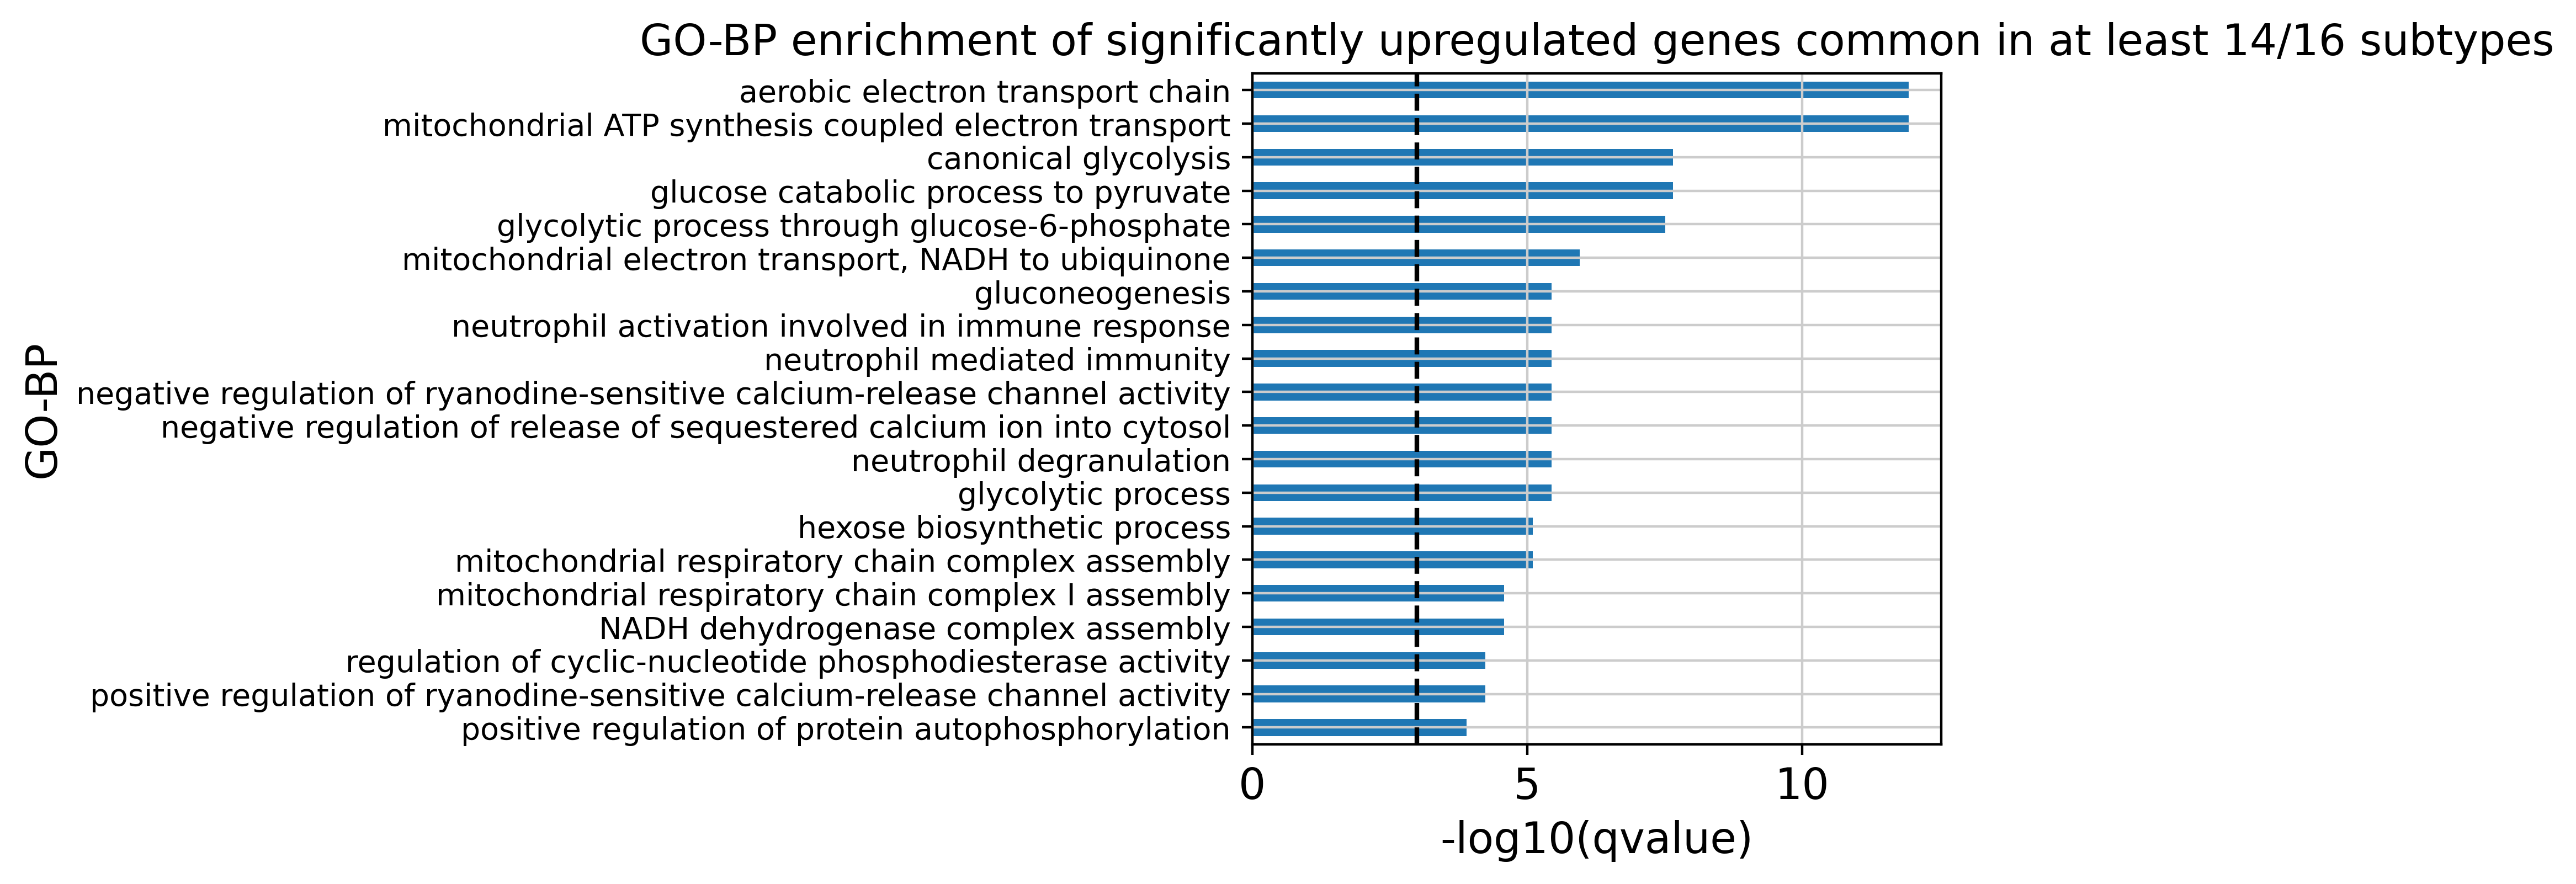

In [73]:
res = {}
for f in os.listdir(basepath):
    results_cleaned = get_sig_results(results_dict[f].copy(), qval_thres=0.05, lfc_abs_thres=0.5, lfc_dir="up")
    results_sets, occurrence_inv, occurrence = get_occurrence(results_cleaned)
    # get genes expressed in at least half the protocols
    genes = []
    for i in range(np.int32(np.ceil(len(results_cleaned)/2)), max(occurrence_inv.keys())+1):
        genes += occurrence_inv[i]
    res[f.split(".xlsx")[0]] = genes
results_sets, occurrence_inv, occurrence = get_occurrence(res)
enr_upregulated = enrichr(occurrence_inv[16]+occurrence_inv[15]+occurrence_inv[14], background=cleaned_features, nterms=20)
plt.yticks(fontsize=10)
plt.title("GO-BP enrichment of significantly upregulated genes common in at least 14/16 subtypes")
plt.savefig("/storage/data/neural_subtype_de/common_de_genes/go_enrichment_common_upregulated_genes.png", dpi=300, bbox_inches='tight')

In [74]:
df_upregulated = pd.DataFrame(index=["de_in_n_subtypes"], data=occurrence).T

622 de genes


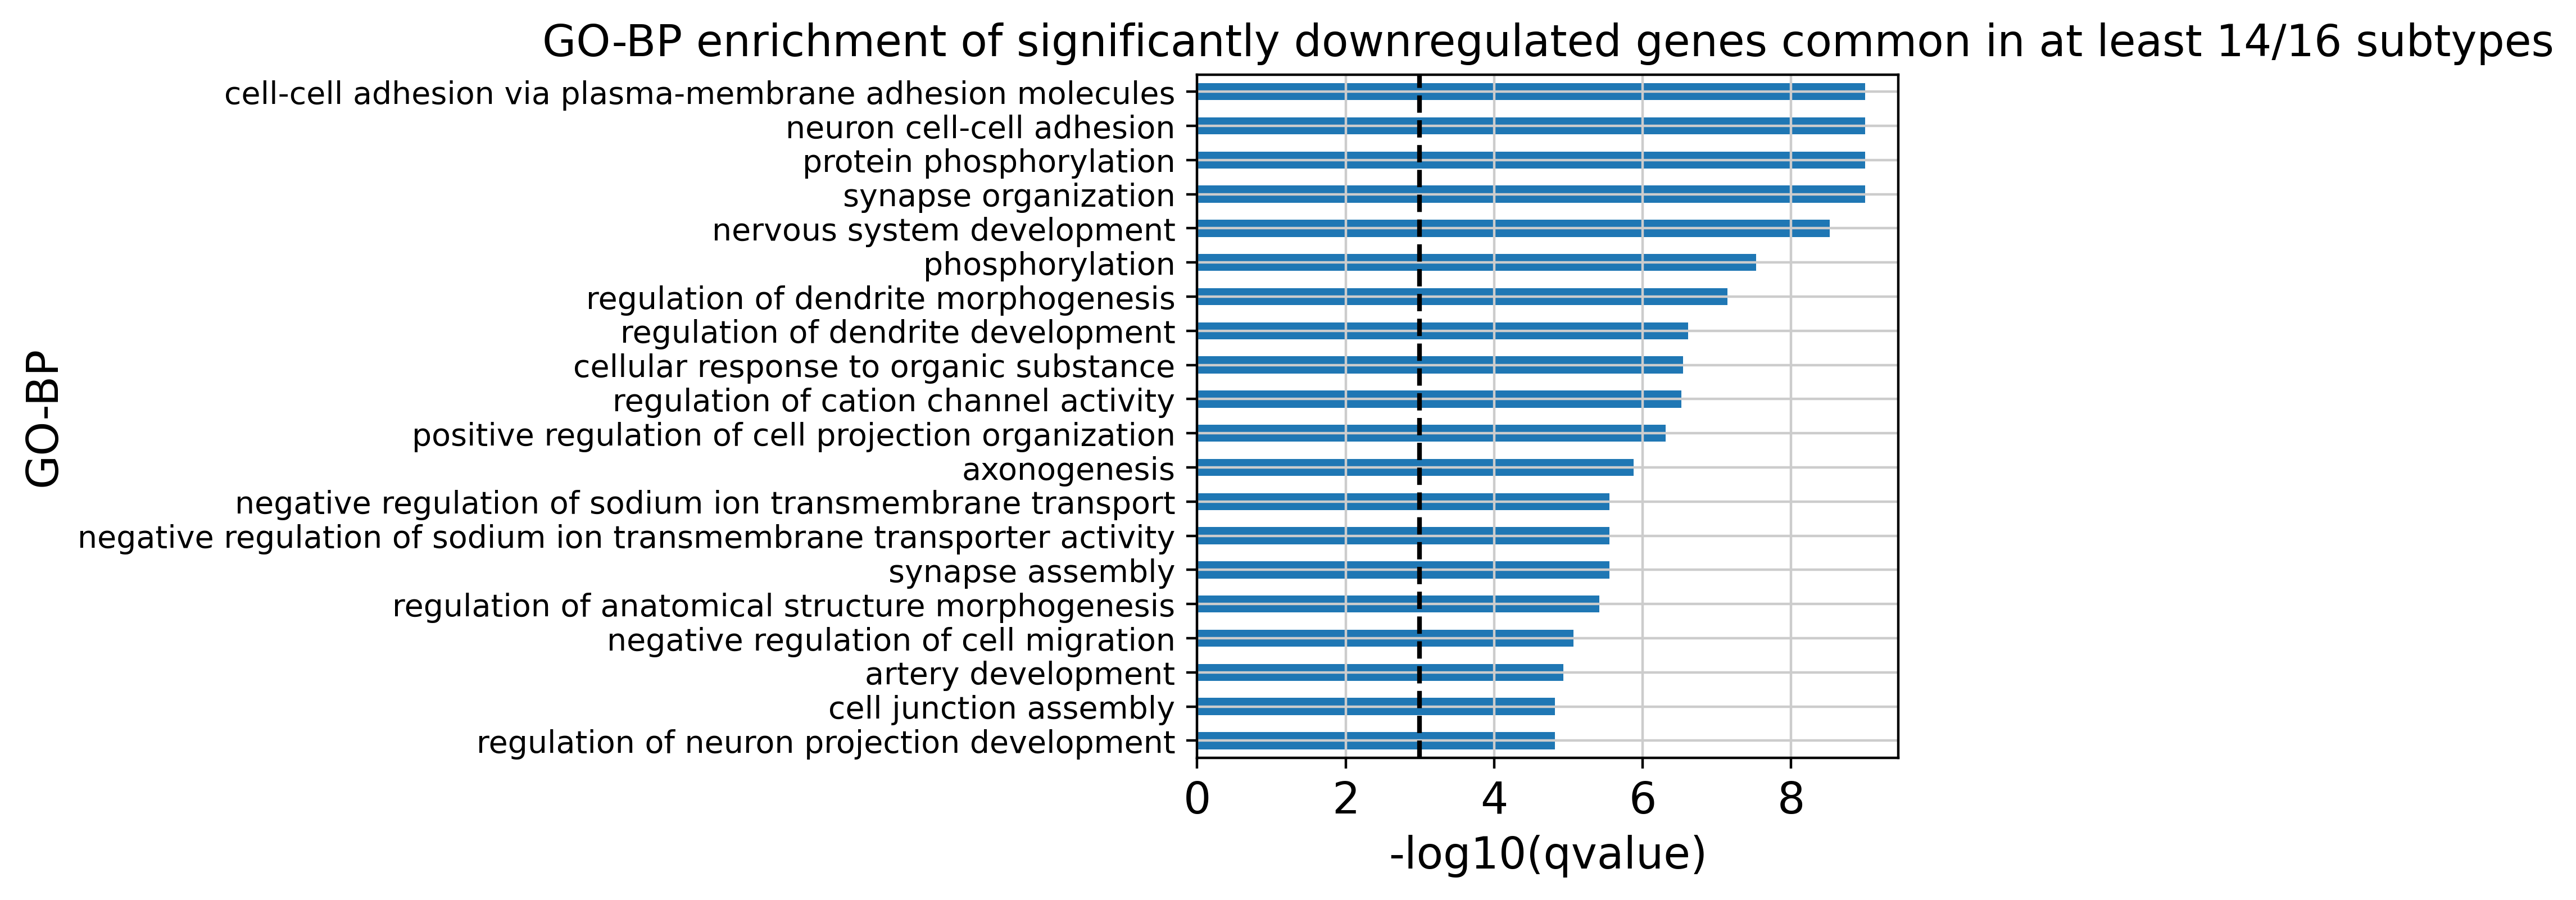

In [75]:
basepath = "/storage/data/neural_subtype_de/all_cluster_de/"
res = {}
for f in os.listdir(basepath):
    results_cleaned = get_sig_results(results_dict[f].copy(), qval_thres=0.05, lfc_abs_thres=0.5, lfc_dir="down")
    results_sets, occurrence_inv, occurrence = get_occurrence(results_cleaned)
    # get genes expressed in at least half the protocols
    genes = []
    for i in range(np.int32(np.ceil(len(results_cleaned)/2)), max(occurrence_inv.keys())+1):
        genes += occurrence_inv[i]
    res[f.split(".xlsx")[0]] = genes
results_sets, occurrence_inv, occurrence = get_occurrence(res)
enr_downregulated = enrichr(occurrence_inv[16]+occurrence_inv[15]+occurrence_inv[14], background=cleaned_features, nterms=20)
plt.yticks(fontsize=10)
plt.title("GO-BP enrichment of significantly downregulated genes common in at least 14/16 subtypes")
plt.savefig("/storage/data/neural_subtype_de/common_de_genes/go_enrichment_common_downregulated_genes.png", dpi=300, bbox_inches='tight')

In [76]:
df_downregulated = pd.DataFrame(index=["de_in_n_subtypes"], data=occurrence).T

In [77]:
results = {}
with pd.ExcelWriter("/storage/data/neural_subtype_de/common_de_genes/occurrence_up_downregulated_genes.xlsx", engine='xlsxwriter') as writer:
    df_upregulated.to_excel(writer, sheet_name="occurrence_upregulated_genes")
    df_downregulated.to_excel(writer, sheet_name="occurrence_downregulated_genes")

In [78]:
results = {}
with pd.ExcelWriter("/storage/data/neural_subtype_de/common_de_genes/enrichment_common_de_inatleast14of16_subtypes.xlsx", engine='xlsxwriter') as writer:
    enr_upregulated.to_excel(writer, sheet_name="enrichment_upregulated_genes")
    enr_downregulated.to_excel(writer, sheet_name="enrichment_downregulated_genes")

# Filter glycolytic cells

In [17]:
adata_merge = anndata.concat([adata, adata_braun, adata_eze, adata_camp])

In [18]:
# load go terms downloaded from enrichr webpage
go_dict = {}
with open("/storage/data/neural_subtype_de/enrichment/GO_Biological_Process_2021GO_Biological_Process_2021", 'r') as f:
    for l in f.readlines():
        if l.startswith(("canonical glycolysis",)): # "aerobic electron transport chain", "mitochondrial ATP synthesis coupled electron transport"
            go_dict[l.split(" (")[0]] = l.split("\t")[2:-1]

In [19]:
adata_merge.X = adata_merge.layers["counts"].copy()
sc.pp.normalize_total(adata_merge, target_sum=1e6)
sc.pp.log1p(adata_merge)

normalizing counts per cell
    finished (0:00:14)


In [20]:
adata_merge.layers["lognorm"] = adata_merge.X.copy()
adata_merge.layers["scaled"] = sc.pp.scale(adata_merge, zero_center=False, copy=True).X

In [21]:
adata_merge.obs["publication_protocol"] = adata_merge.obs["publication"] + "_" + adata_merge.obs["assay_differentiation"]

In [22]:
adata_merge.X = adata_merge.layers["scaled"].copy()
for k, v in go_dict.items():
     sc.tl.score_genes(adata_merge, v, score_name=f"{k.replace(' ', '_')}_score")
adata_merge.X = adata_merge.layers["lognorm"].copy()

computing score 'canonical_glycolysis_score'
    finished: added
    'canonical_glycolysis_score', score of gene set (adata.obs).
    745 total control genes are used. (0:00:59)


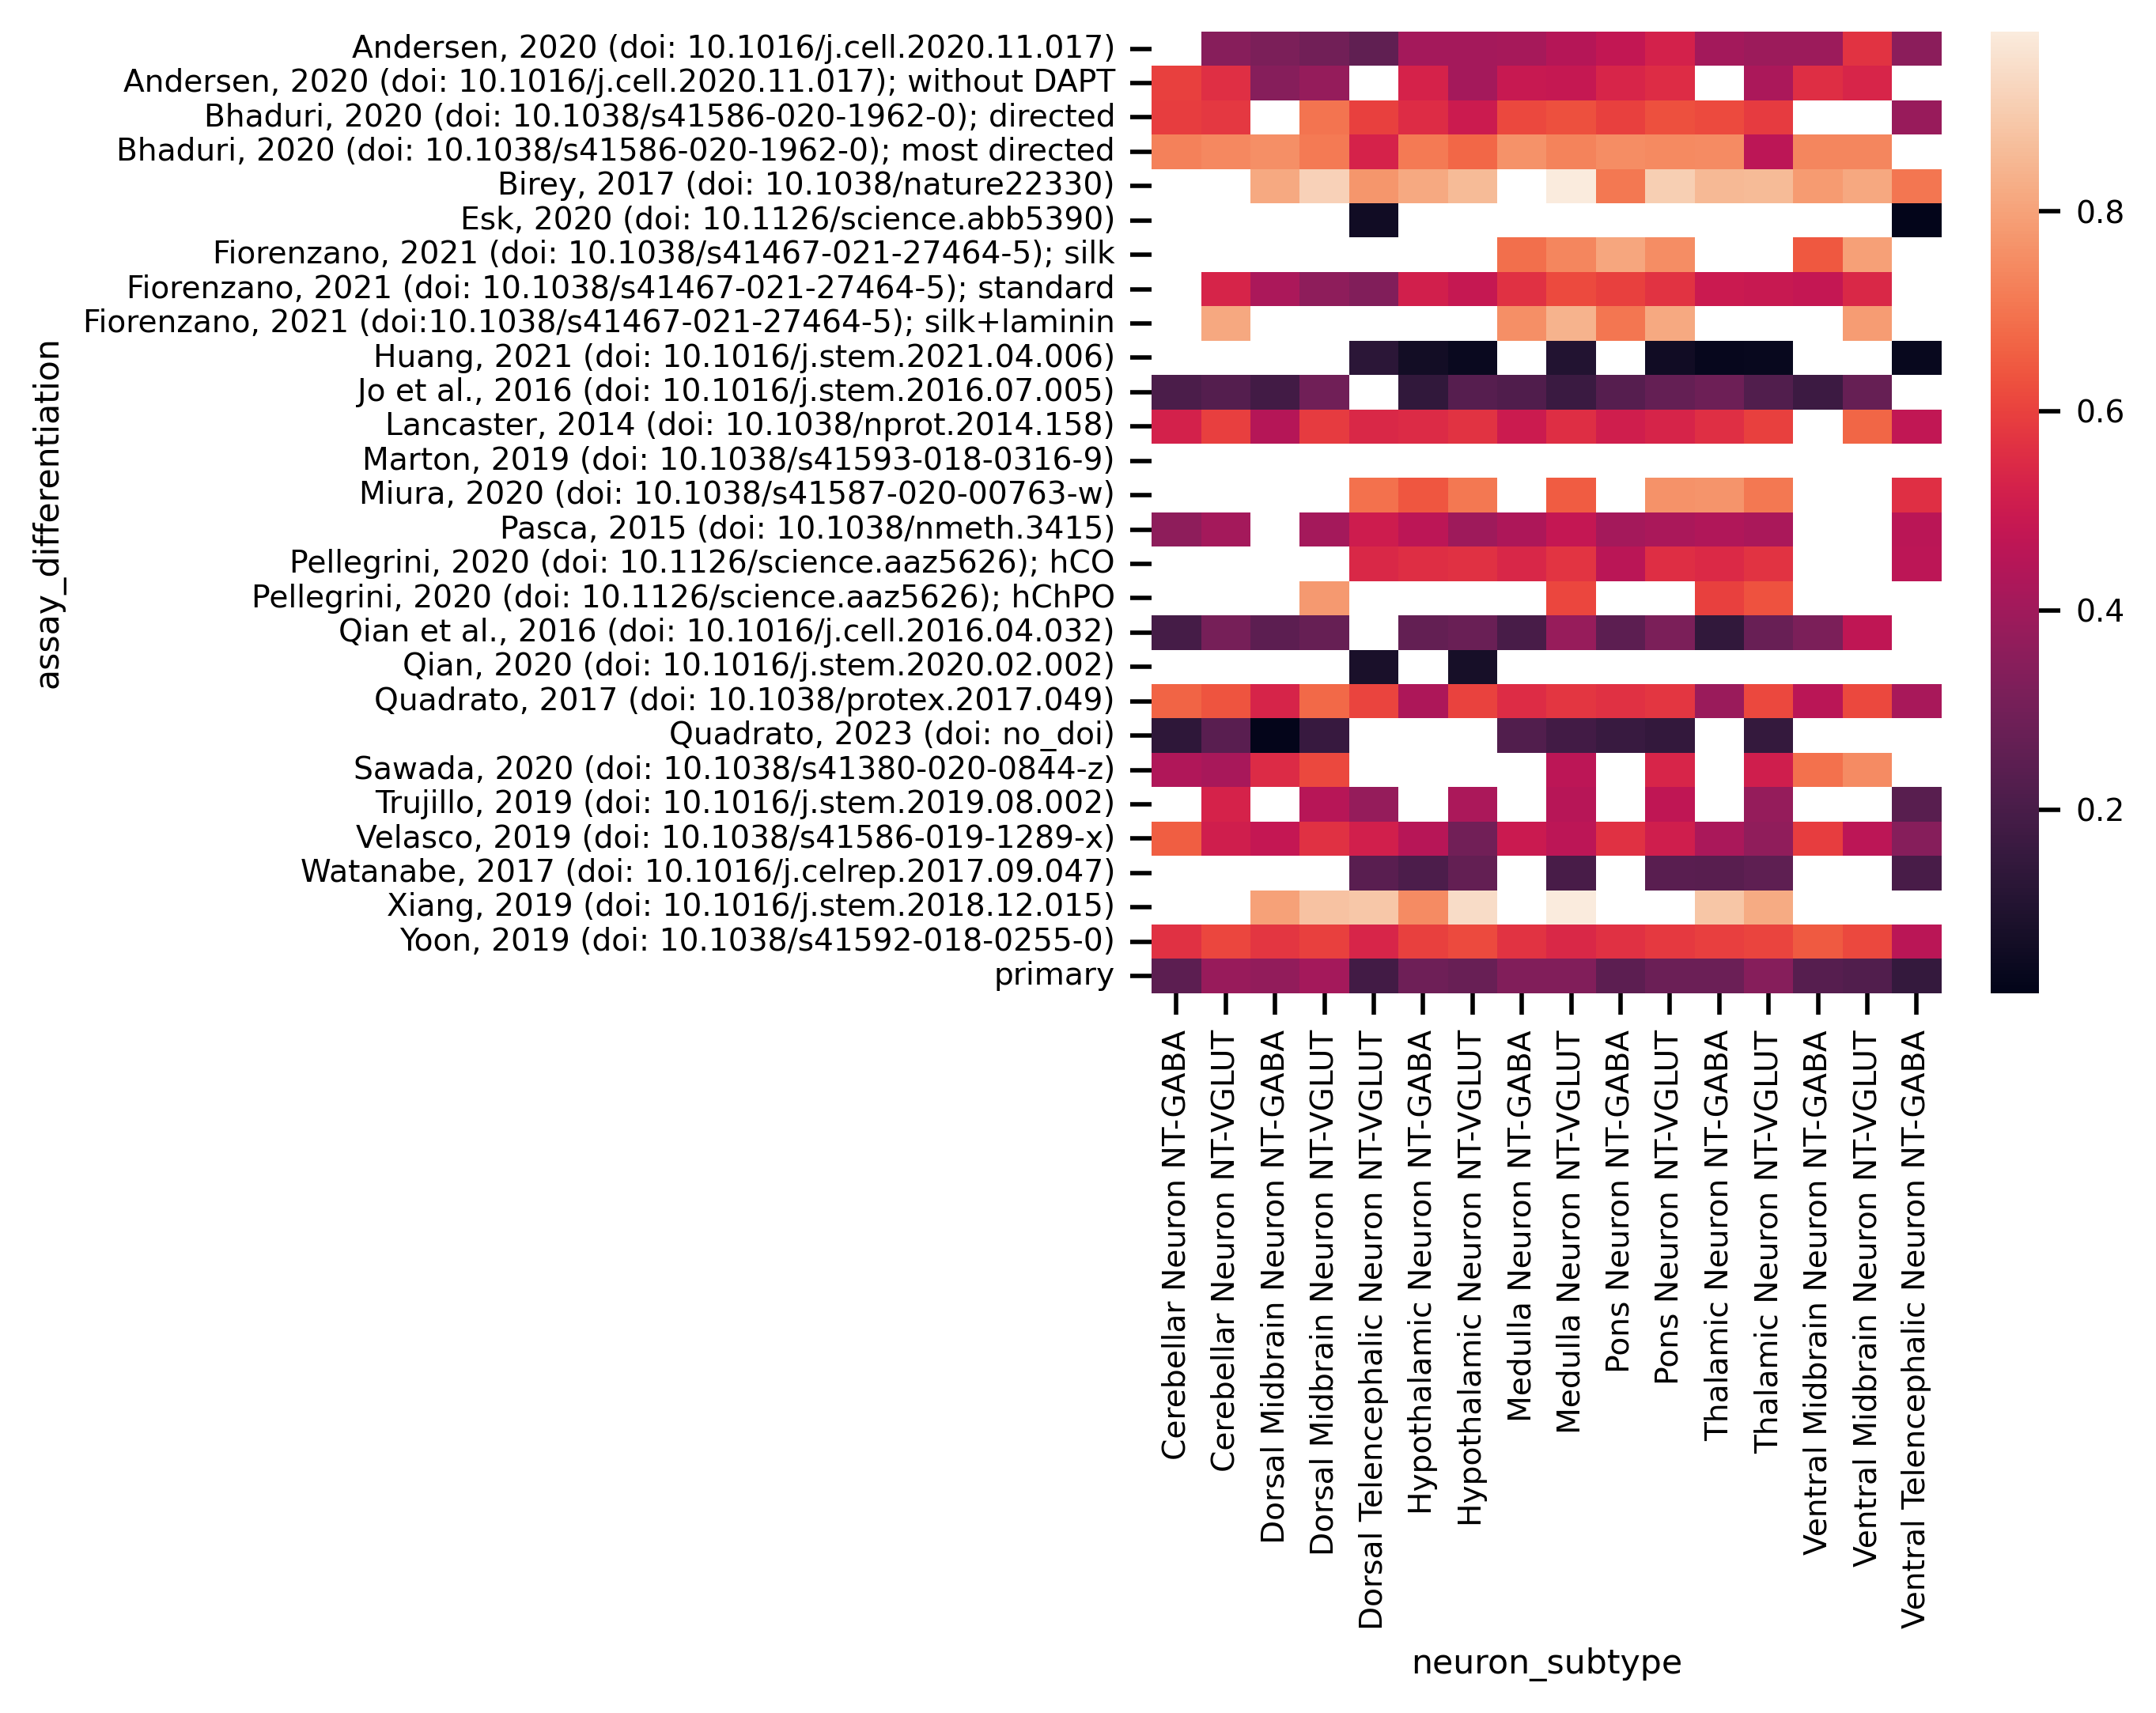

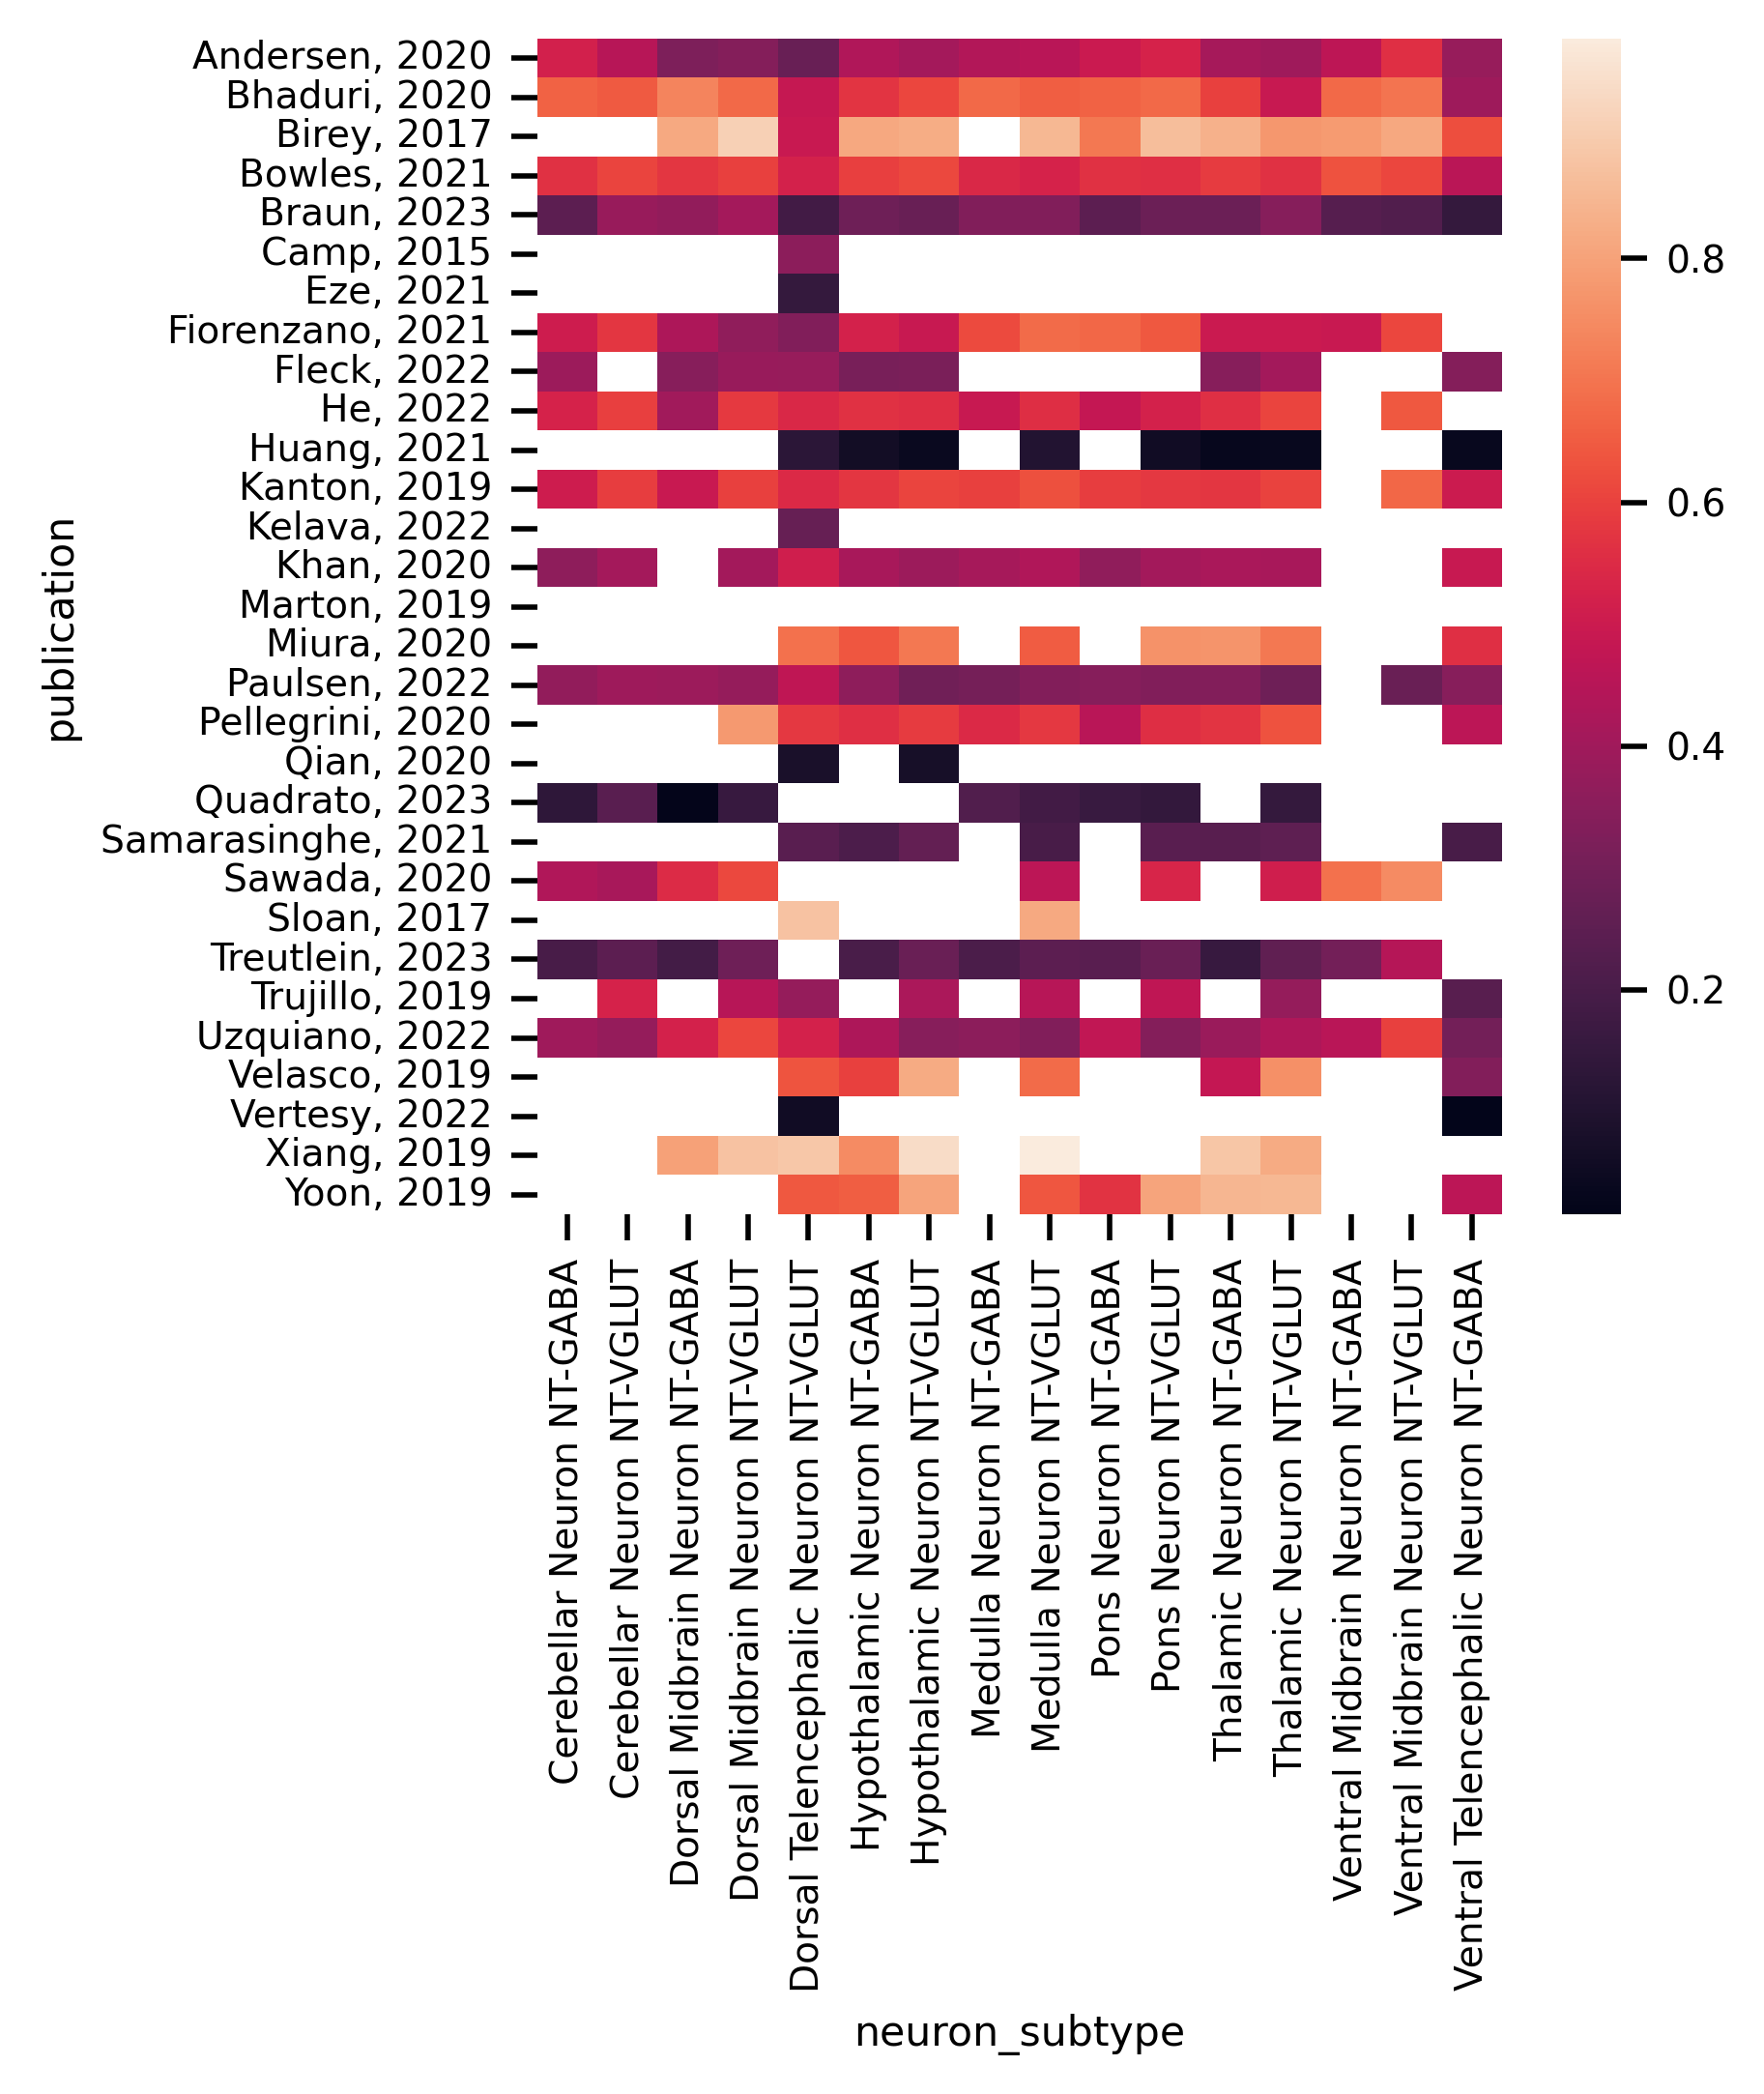

In [24]:
clusters = [i for i in adata.obs["neuron_subtype"].value_counts().index if "NT-VGLUT" in i or "NT-GABA" in i]
a = adata_merge[adata_merge.obs["neuron_subtype"].isin(clusters)]

df = pd.crosstab(a.obs["assay_differentiation"], a.obs["neuron_subtype"], a.obs["canonical_glycolysis_score"], aggfunc=np.mean)
df[pd.crosstab(a.obs["assay_differentiation"], a.obs["neuron_subtype"], a.obs["canonical_glycolysis_score"], aggfunc=np.count_nonzero)<20] = np.nan
with mpl.rc_context({"axes.grid" : False}):
    with sns.plotting_context("paper", font_scale=0.8):
        ax = sns.heatmap(df, yticklabels=True, xticklabels=True)
plt.show()

df = pd.crosstab(a.obs["publication"], a.obs["neuron_subtype"], a.obs["canonical_glycolysis_score"], aggfunc=np.mean)
df[pd.crosstab(a.obs["publication"], a.obs["neuron_subtype"], a.obs["canonical_glycolysis_score"], aggfunc=np.count_nonzero)<20] = np.nan
with mpl.rc_context({"axes.grid" : False}):
    with sns.plotting_context("paper", font_scale=0.8):
        ax = sns.heatmap(df, yticklabels=True, xticklabels=True)
plt.show()

In [29]:
adata_merge.obs.groupby("publication_protocol").quantile(0.5)["canonical_glycolysis_score"].sort_values()

publication_protocol
Vertesy, 2022_Esk, 2020 (doi: 10.1126/science.abb5390)                              0.012451
Huang, 2021_Huang, 2021 (doi: 10.1016/j.stem.2021.04.006)                           0.040855
Qian, 2020_Qian, 2020 (doi: 10.1016/j.stem.2020.02.002)                             0.042442
Eze, 2021_primary                                                                   0.133137
Quadrato, 2023_Quadrato, 2023 (doi: no_doi)                                         0.158860
Treutlein, 2023_Jo et al., 2016 (doi: 10.1016/j.stem.2016.07.005)                   0.161116
Treutlein, 2023_Qian et al., 2016 (doi: 10.1016/j.cell.2016.04.032)                 0.206665
Samarasinghe, 2021_Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)               0.207097
Braun, 2023_primary                                                                 0.232519
Kelava, 2022_Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hCO                   0.259496
Fleck, 2022_Lancaster, 2014 (doi: 10.1038/nprot.2

In [25]:
adata_merge.obs.groupby("publication_protocol").mean()["canonical_glycolysis_score"].sort_values()

publication_protocol
Vertesy, 2022_Esk, 2020 (doi: 10.1126/science.abb5390)                              0.044778
Huang, 2021_Huang, 2021 (doi: 10.1016/j.stem.2021.04.006)                           0.057701
Qian, 2020_Qian, 2020 (doi: 10.1016/j.stem.2020.02.002)                             0.082258
Eze, 2021_primary                                                                   0.150876
Quadrato, 2023_Quadrato, 2023 (doi: no_doi)                                         0.179664
Treutlein, 2023_Jo et al., 2016 (doi: 10.1016/j.stem.2016.07.005)                   0.220589
Samarasinghe, 2021_Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)               0.238374
Braun, 2023_primary                                                                 0.249578
Kelava, 2022_Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hCO                   0.270610
Treutlein, 2023_Qian et al., 2016 (doi: 10.1016/j.cell.2016.04.032)                 0.274032
Fleck, 2022_Lancaster, 2014 (doi: 10.1038/nprot.2

In [26]:
adata_merge.obs.to_csv("/storage/data/neural_subtype_de/obs_stress_scores_scaled.tsv", sep="\t")

In [27]:
adata_merge.X = adata_merge.layers["lognorm"].copy()
del adata_merge.layers["lognorm"]

In [28]:
adata_merge.write("/mnt/data/230712_subtype_de_analysis/adata_merge_stressscores.h5ad")

In [33]:
# Remove using absolute cutoff
adata_merge_stressfilt = adata_merge[adata_merge.obs["canonical_glycolysis_score"] < 0.6]
display(1-(adata_merge_stressfilt.obs["publication_protocol"].value_counts() / adata_merge.obs["publication_protocol"].value_counts()).sort_values())

Sloan, 2017_Pasca, 2015 (doi: 10.1038/nmeth.3415)                                   0.758065
Xiang, 2019_Xiang, 2019 (doi: 10.1016/j.stem.2018.12.015)                           0.738663
Birey, 2017_Birey, 2017 (doi: 10.1038/nature22330)                                  0.697637
Fiorenzano, 2021_Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); silk           0.686631
Fiorenzano, 2021_Fiorenzano, 2021 (doi:10.1038/s41467-021-27464-5); silk+laminin    0.654966
Yoon, 2019_Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)                              0.546022
Pellegrini, 2020_Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hChPO             0.507952
Bhaduri, 2020_Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); most directed         0.501584
Miura, 2020_Miura, 2020 (doi: 10.1038/s41587-020-00763-w)                           0.483102
Bhaduri, 2020_Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); directed              0.471460
Velasco, 2019_Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)          

# Validation analyis: Cortical DE using two fetal datasets (Velasco vs. Eze & Braun)

In [201]:
robjects.r('''
    edger_test <- function(coef){
        test <- glmQLFTest(fit, coef=coef)
        tt <- topTags(test, n = Inf)
        return(tt$table)
    }
''')
edger_test = robjects.globalenv['edger_test']

def run_edger_test(coef, plot=True):
    out = robjects.conversion.rpy2py(edger_test(coef))
    out.columns = ["log2fc", "logCPM", "F", "pval", "qval"]
    out = out[["pval", "qval", "log2fc", "logCPM", "F"]]
    out["log2fc_abs"] = out["log2fc"].abs()
    if plot:
        dc.plot_volcano_df(out, x='log2fc', y='qval', top=30, figsize=(8,8))
        plt.show()
    return out

In [202]:
adata_sub = adata[(adata.obs["neuron_subtype"] == "Dorsal Telencephalic Neuron NT-VGLUT") & (adata.obs["assay_sc"].isin(["10x 3' v2"])) & (adata.obs["assay_differentiation"].isin(["Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)", "primary"]))].copy()
adata_braun_sub = adata_braun[(adata_braun.obs["neuron_subtype"] == "Dorsal Telencephalic Neuron NT-VGLUT") & (adata_braun.obs["assay_sc"].isin(["10x 3' v2"]))].copy()
adata_eze_sub = adata_eze[(adata_eze.obs["neuron_subtype"] == "Dorsal Telencephalic Neuron NT-VGLUT") & (adata_eze.obs["assay_sc"].isin(["10x 3' v2"]))].copy()

In [203]:
pdata = create_pseudobulk([adata_sub, adata_braun_sub, adata_eze_sub], "Dorsal Telencephalic Neuron NT-VGLUT")

Number of cells for celltype Dorsal Telencephalic Neuron NT-VGLUT
121280
44541
7996

normalizing counts per cell
    finished (0:00:01)


In [204]:
pdata.obs.loc[:, "assay_differentiation"] = pdata.obs.loc[:, "assay_differentiation"].astype(str)
pdata.obs.loc[pdata.obs["publication"] == "Braun, 2023", "assay_differentiation"] = "Braun, 2023"
pdata.obs.loc[pdata.obs["publication"] == "Eze, 2021", "assay_differentiation"] = "Eze, 2021"
pdata.obs["assay_differentiation"] = pd.Categorical(pdata.obs["assay_differentiation"], categories=['Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)', 'Braun, 2023', 'Eze, 2021'])

In [205]:
%%R -i pdata
# create an edgeR object with counts and grouping factor
y <- DGEList(assay(pdata, "X"), group = colData(pdata)$assay_differentiation)
# filter out genes with low counts
keep <- filterByExpr(y)
y <- y[keep, , keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
# create a design matrix
design <- model.matrix(~ colData(pdata)$psbulk_n_cells + colData(pdata)$organoid_age_days + colData(pdata)$assay_differentiation)
y <- estimateDisp(y, design = design)
fit <- glmQLFit(y, design)
print(colnames(fit))

[1] "(Intercept)"                                    
[2] "colData(pdata)$psbulk_n_cells"                  
[3] "colData(pdata)$organoid_age_days"               
[4] "colData(pdata)$assay_differentiationBraun, 2023"
[5] "colData(pdata)$assay_differentiationEze, 2021"  


In [206]:
protocol_keys = {
    'Braun, 2023': 4,
    'Eze, 2021': 5,
}

Braun, 2023


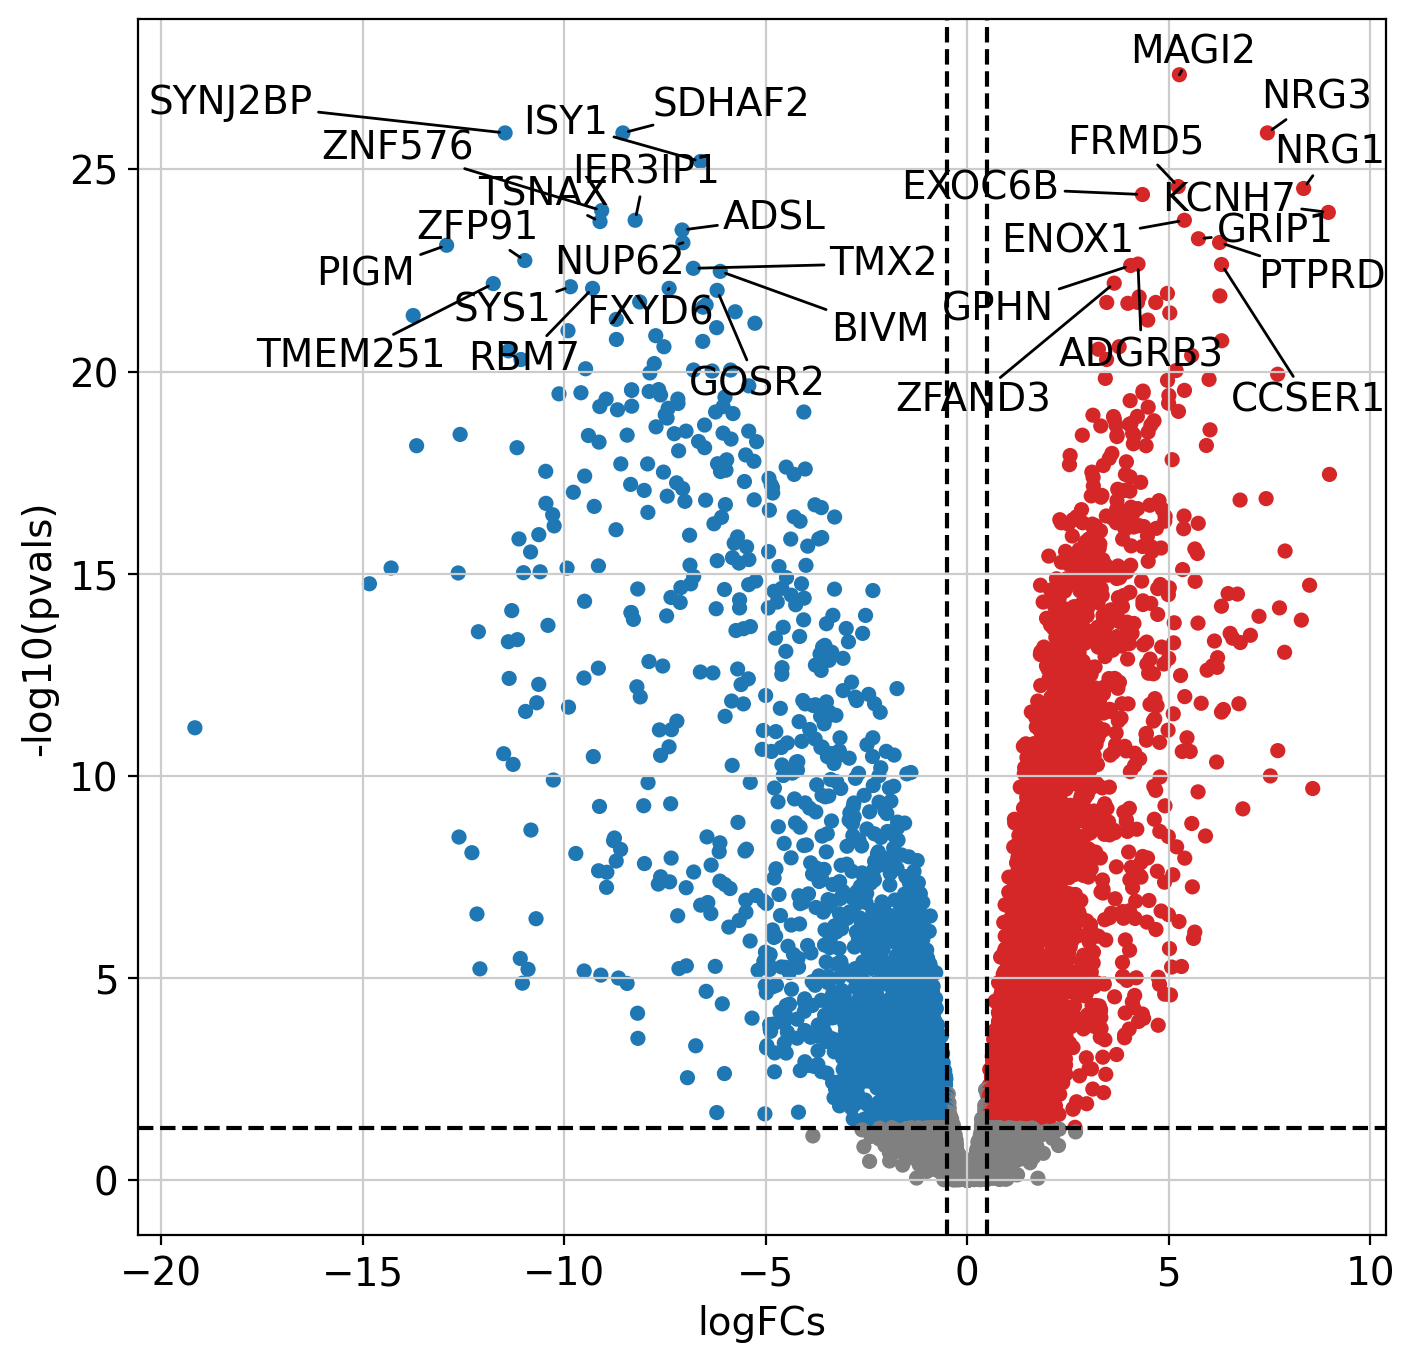

Braun, 2023 6052
Eze, 2021


<Figure size 800x800 with 0 Axes>

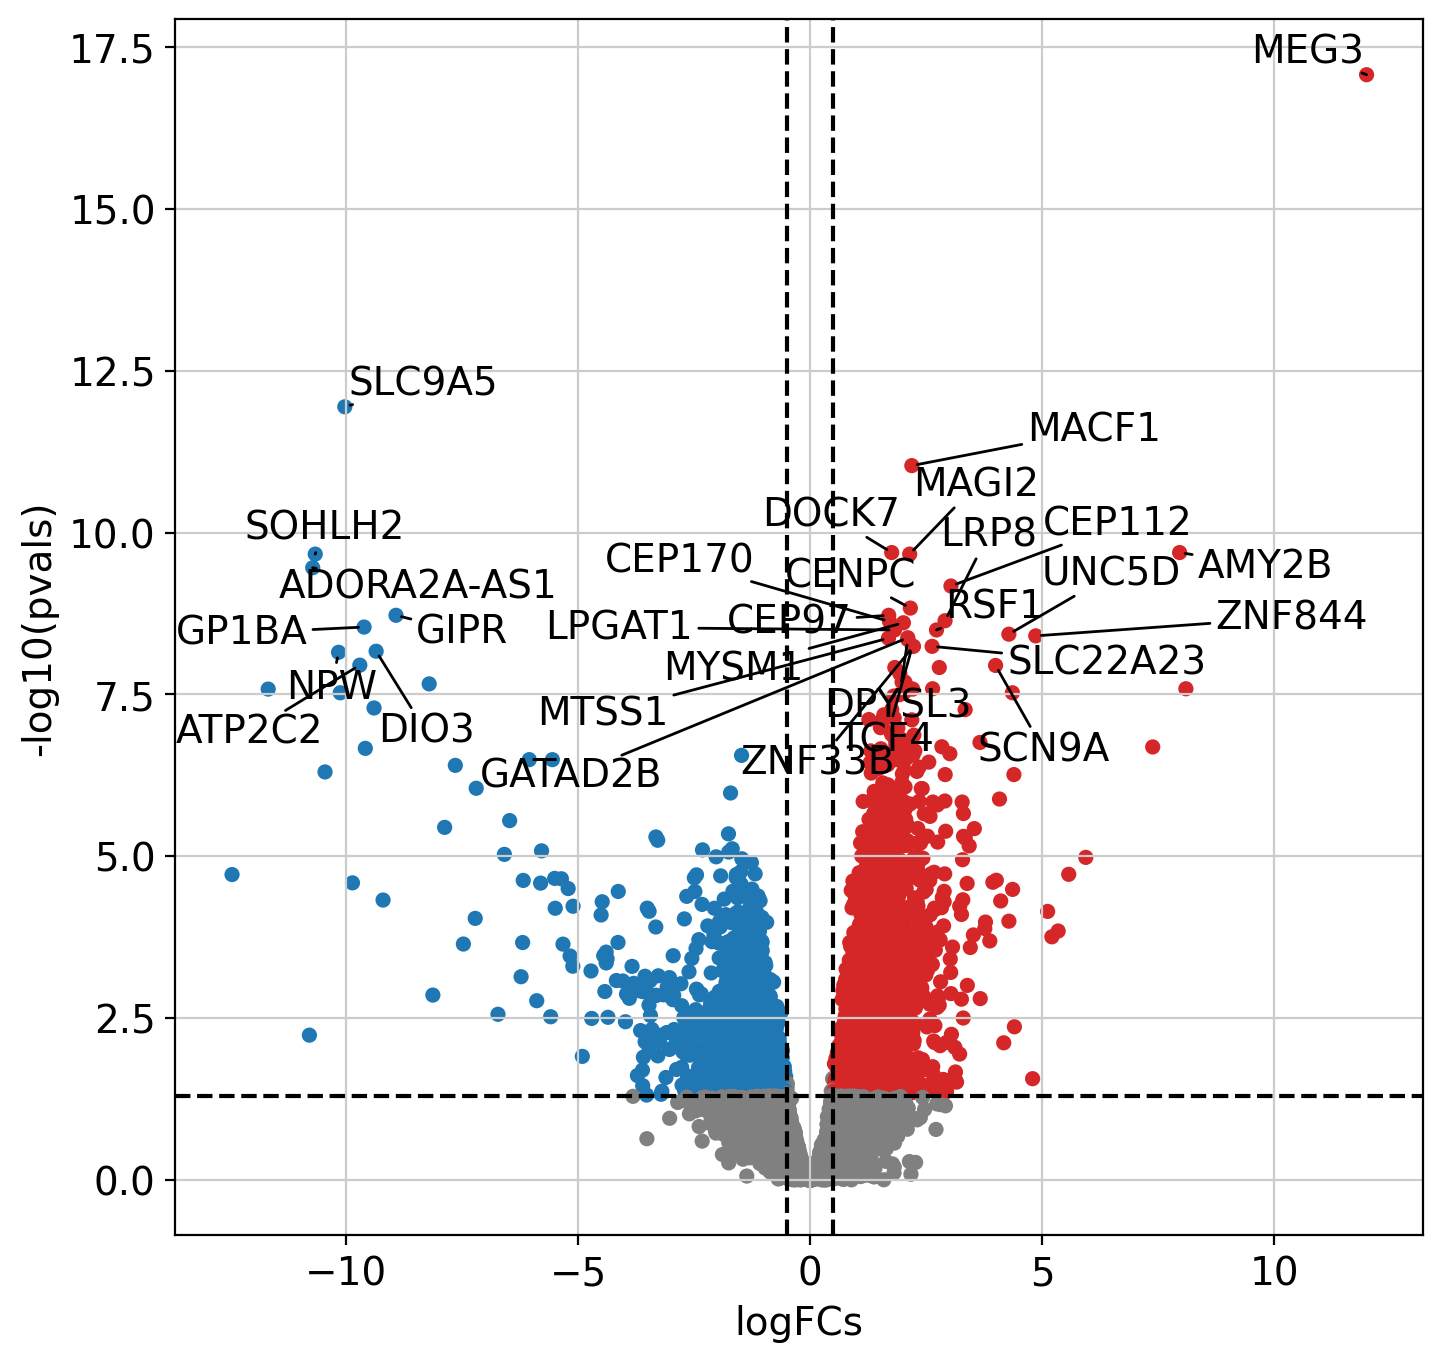

Eze, 2021 3999


<Figure size 800x800 with 0 Axes>

In [207]:
results = {}
with pd.ExcelWriter("/storage/data/neural_subtype_de/velasco_vs_twoprimary/velasco_vs_twoprimary.xlsx", engine='xlsxwriter') as writer:
    for name, coef in protocol_keys.items():
        print(name)
        results[name] = run_edger_test(coef).sort_values("qval")
        plt.savefig(f"/storage/data/neural_subtype_de/velasco_vs_twoprimary/volcano_{name.split(',')[0]}.pdf", bbox_inches="tight")
        print(name, len(results[name].loc[(results[name]["qval"] < 0.05) & (results[name]["log2fc_abs"] > 0.5)]))
        results[name].to_excel(writer, sheet_name=name)

In [34]:
results = pd.read_excel("/storage/data/neural_subtype_de/velasco_vs_twoprimary/velasco_vs_twoprimary.xlsx", sheet_name=None, index_col=0)
results_cleaned = {}
for k in results.keys():
    results_cleaned[k] = results[k].loc[results[k]["log2fc_abs"] > 0.5].copy()
    results_cleaned[k] = results[k].loc[results[k]["qval"] < 0.05].copy()
    print(len(results_cleaned[k]), k)

6167 Braun, 2023
4009 Eze, 2021


In [35]:
results_sets = {}
for k in results_cleaned.keys():
    results_sets[k] = set(results_cleaned[k].index)
all_genes = set()
for k in results_sets.keys():
    all_genes |= results_sets[k]
all_genes = list(all_genes)

occurrence = {}
for g in all_genes:
    c = 0
    for k in results_sets.keys():
        if g in results_sets[k]:
            c += 1
    occurrence[g] = c

occurrence_inv = {i+1:[] for i in range(max(set(occurrence.values())))}
for k, v in occurrence.items():
    occurrence_inv[v].append(k)

for k, v in occurrence_inv.items():
    occurrence_inv[k] = sorted(v)

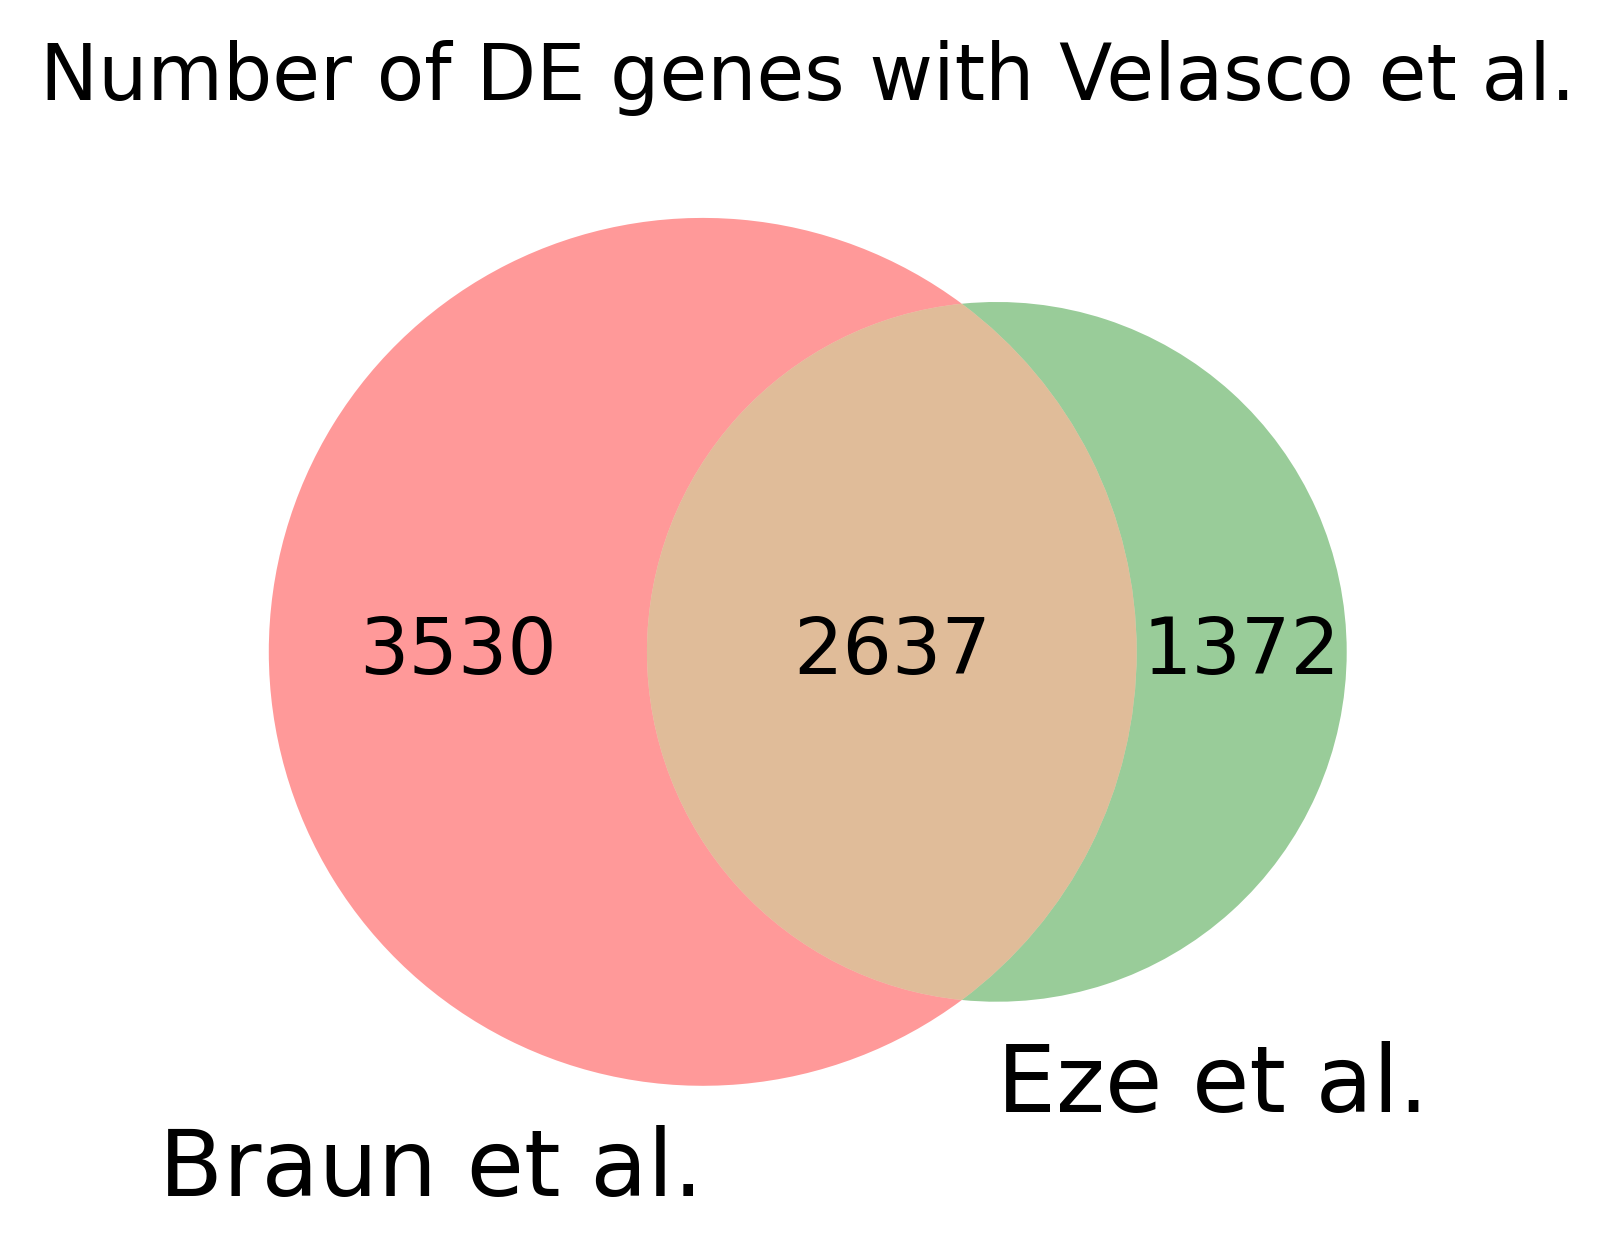

In [36]:
venn2((set(results_cleaned["Braun, 2023"].index),set(results_cleaned["Eze, 2021"].index)), set_labels=("Braun et al.", "Eze et al."))
plt.title("Number of DE genes with Velasco et al.")
plt.savefig("/storage/data/neural_subtype_de/velasco_vs_twoprimary/venn.pdf", bbox_inches="tight")
plt.show()

In [37]:
def clustermap(lower, upper, protocols=None, cluster_cut=None, optimal_ordering=False, nonsiglfc=False):
    accepted_genes = []
    for i in range(lower-1,upper):
        accepted_genes += occurrence_inv[i+1]
    accepted_genes = sorted(accepted_genes)
    print(len(accepted_genes), "genes shared between", lower, "and", upper, "protocols")

    df = pd.DataFrame(index=accepted_genes)
    df_dense = pd.DataFrame(index=accepted_genes)
    if protocols is None:
        protocols = results_sets.keys()
    for k in protocols:
        col = []
        col_dense = []
        for g in accepted_genes:
            if g in results_sets[k]:
                col.append(results_cleaned[k].loc[g, "log2fc"])
            else:
                col.append(0.0)
            col_dense.append(results[k].loc[g, "log2fc"])
        df[k] = col
        df_dense[k] = col_dense

    row_linkage = scipy.cluster.hierarchy.linkage(df_dense.values, method='ward', metric='euclidean', optimal_ordering=optimal_ordering)
    col_linkage = scipy.cluster.hierarchy.linkage(df_dense.values.T, method='ward', metric='euclidean', optimal_ordering=optimal_ordering)
    if cluster_cut is not None:
        clusters = pd.Series(scipy.cluster.hierarchy.fcluster(row_linkage, t=cluster_cut, criterion="distance"), index=df.index)
        cdict = dict(zip(np.unique(clusters), sc.pl.palettes.default_20))
        row_colors = clusters.map(cdict)
    else:
        row_colors = None
        clusters = None
    if nonsiglfc:
        df = df_dense

    sns.clustermap(df, cmap="seismic", row_colors=row_colors, row_linkage=row_linkage, col_linkage=col_linkage, vmax=df.abs().max().max(), vmin=-df.abs().max().max());
    
    if cluster_cut is not None:
        # The following two lines generate custom fake lines that will be used as legend entries:
        markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cdict.values()]
        plt.legend(markers, cdict.keys(), numpoints=1, loc=(20,-1), title="Clusters")
    return clusters

7470 genes shared between 1 and 2 protocols


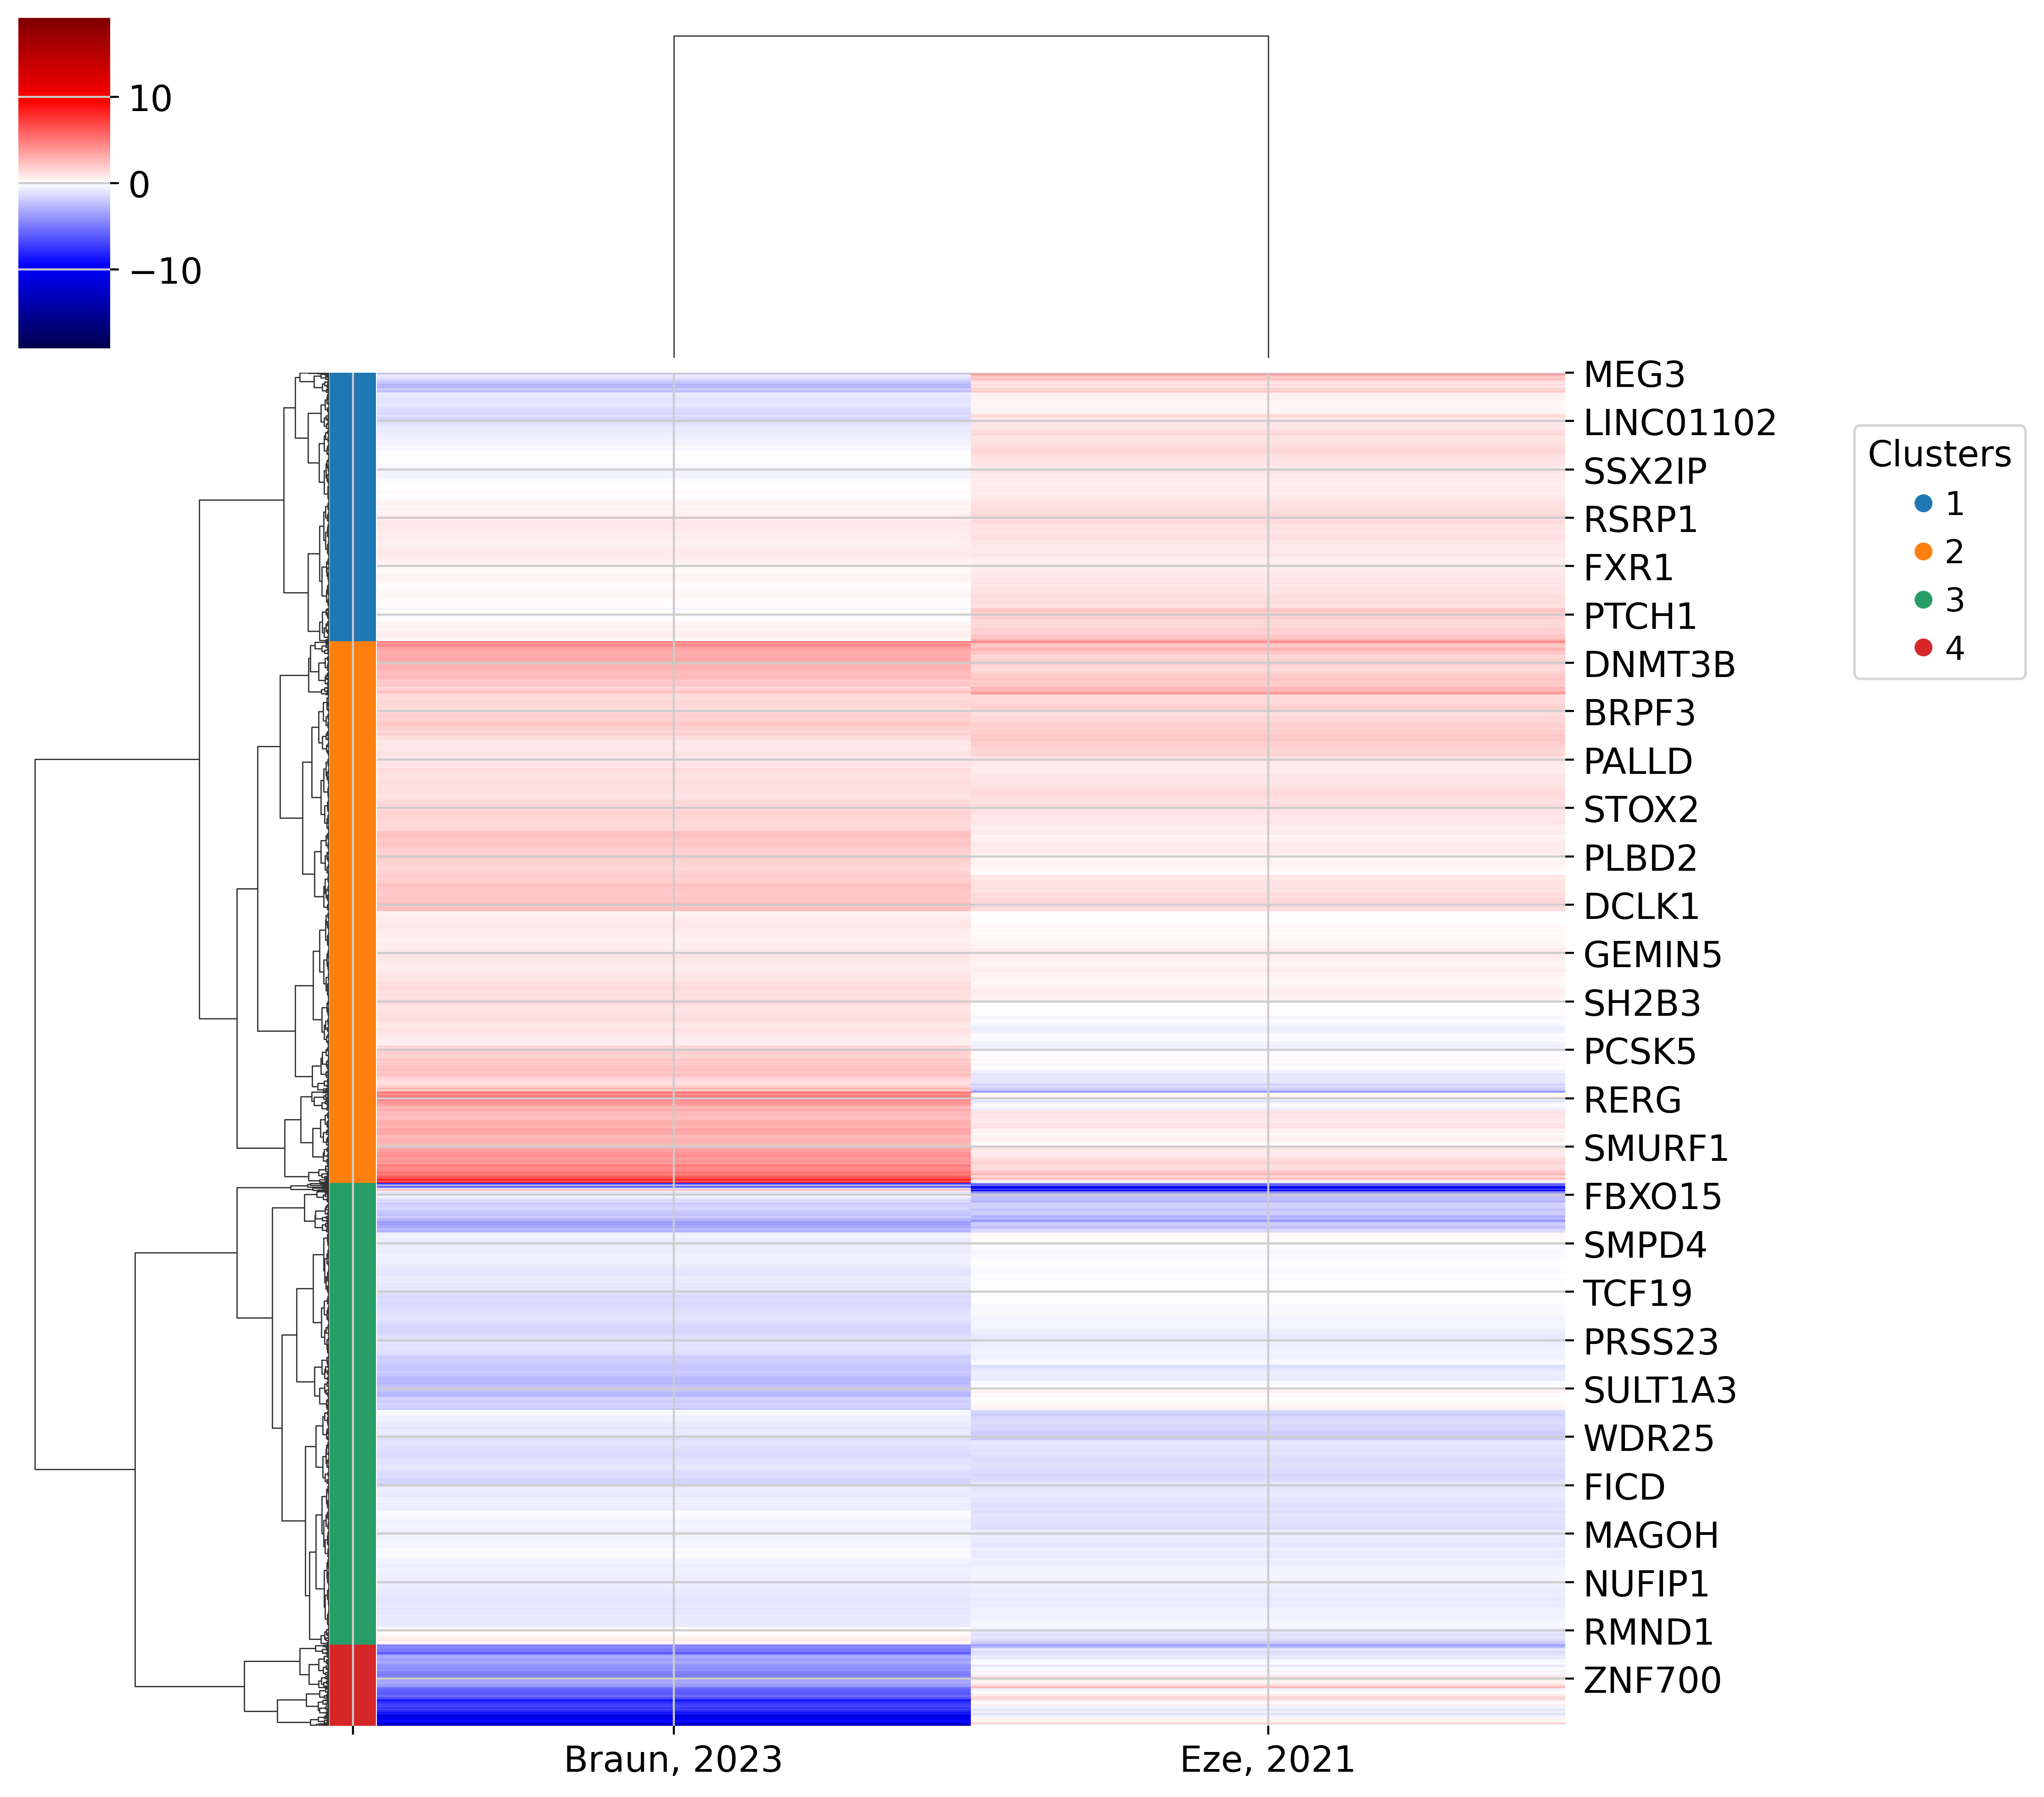

In [216]:
cl = clustermap(1, 2, cluster_cut=80, optimal_ordering=True, nonsiglfc=True)
plt.savefig("/storage/data/neural_subtype_de/velasco_vs_twoprimary/heatmap_allgenes_nonsiglfc_clustered.pdf", bbox_inches="tight")

1484 de genes


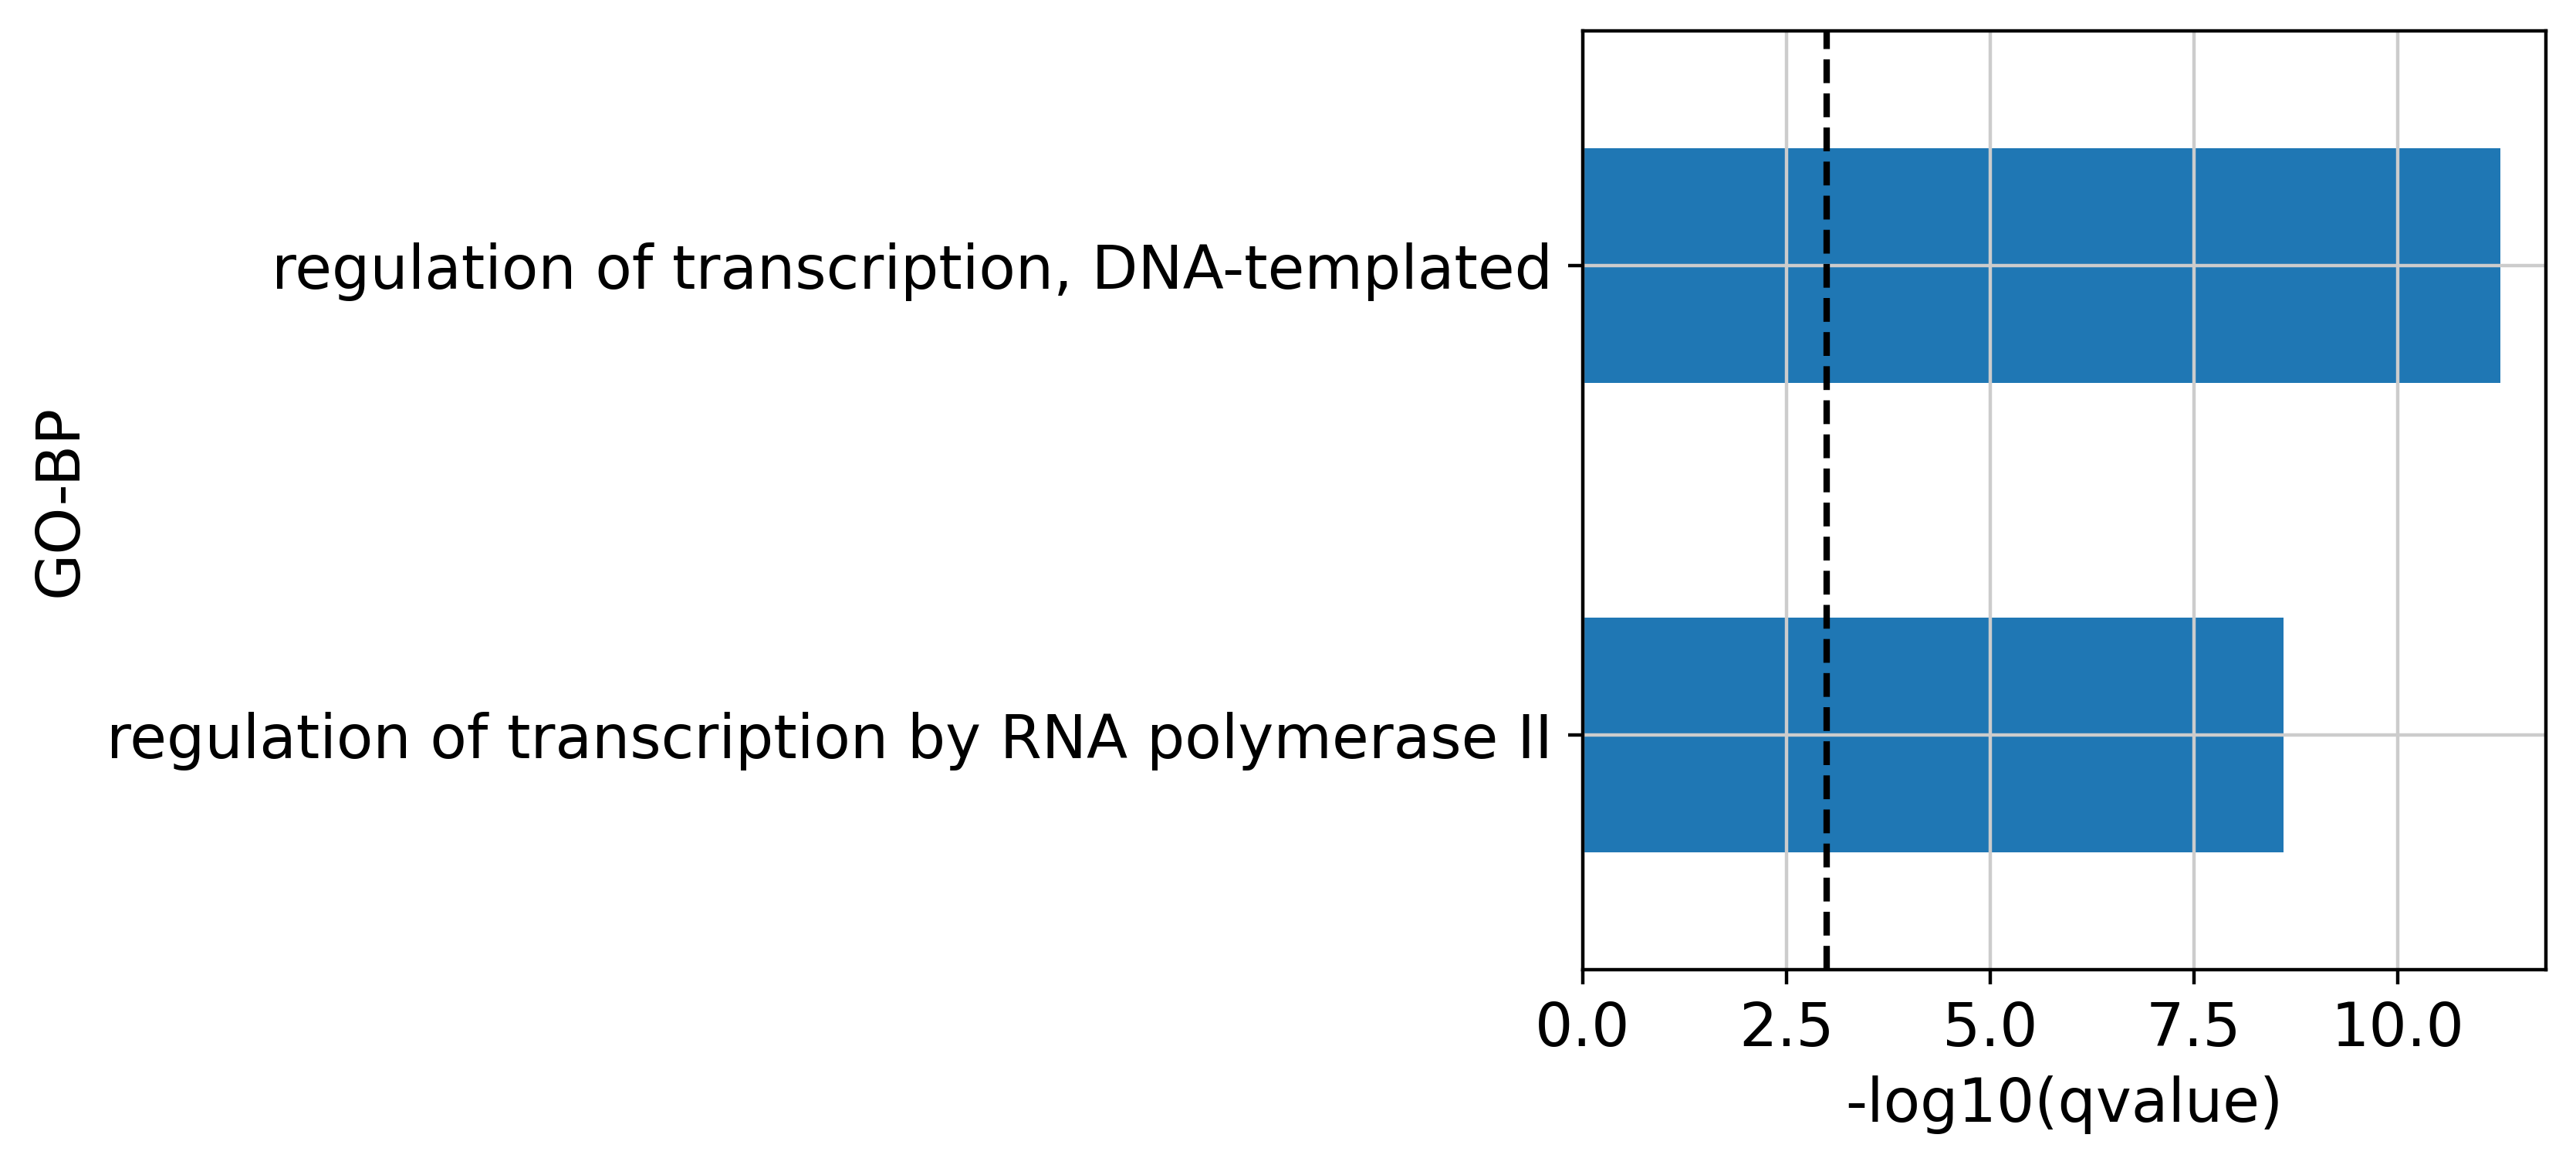

2988 de genes


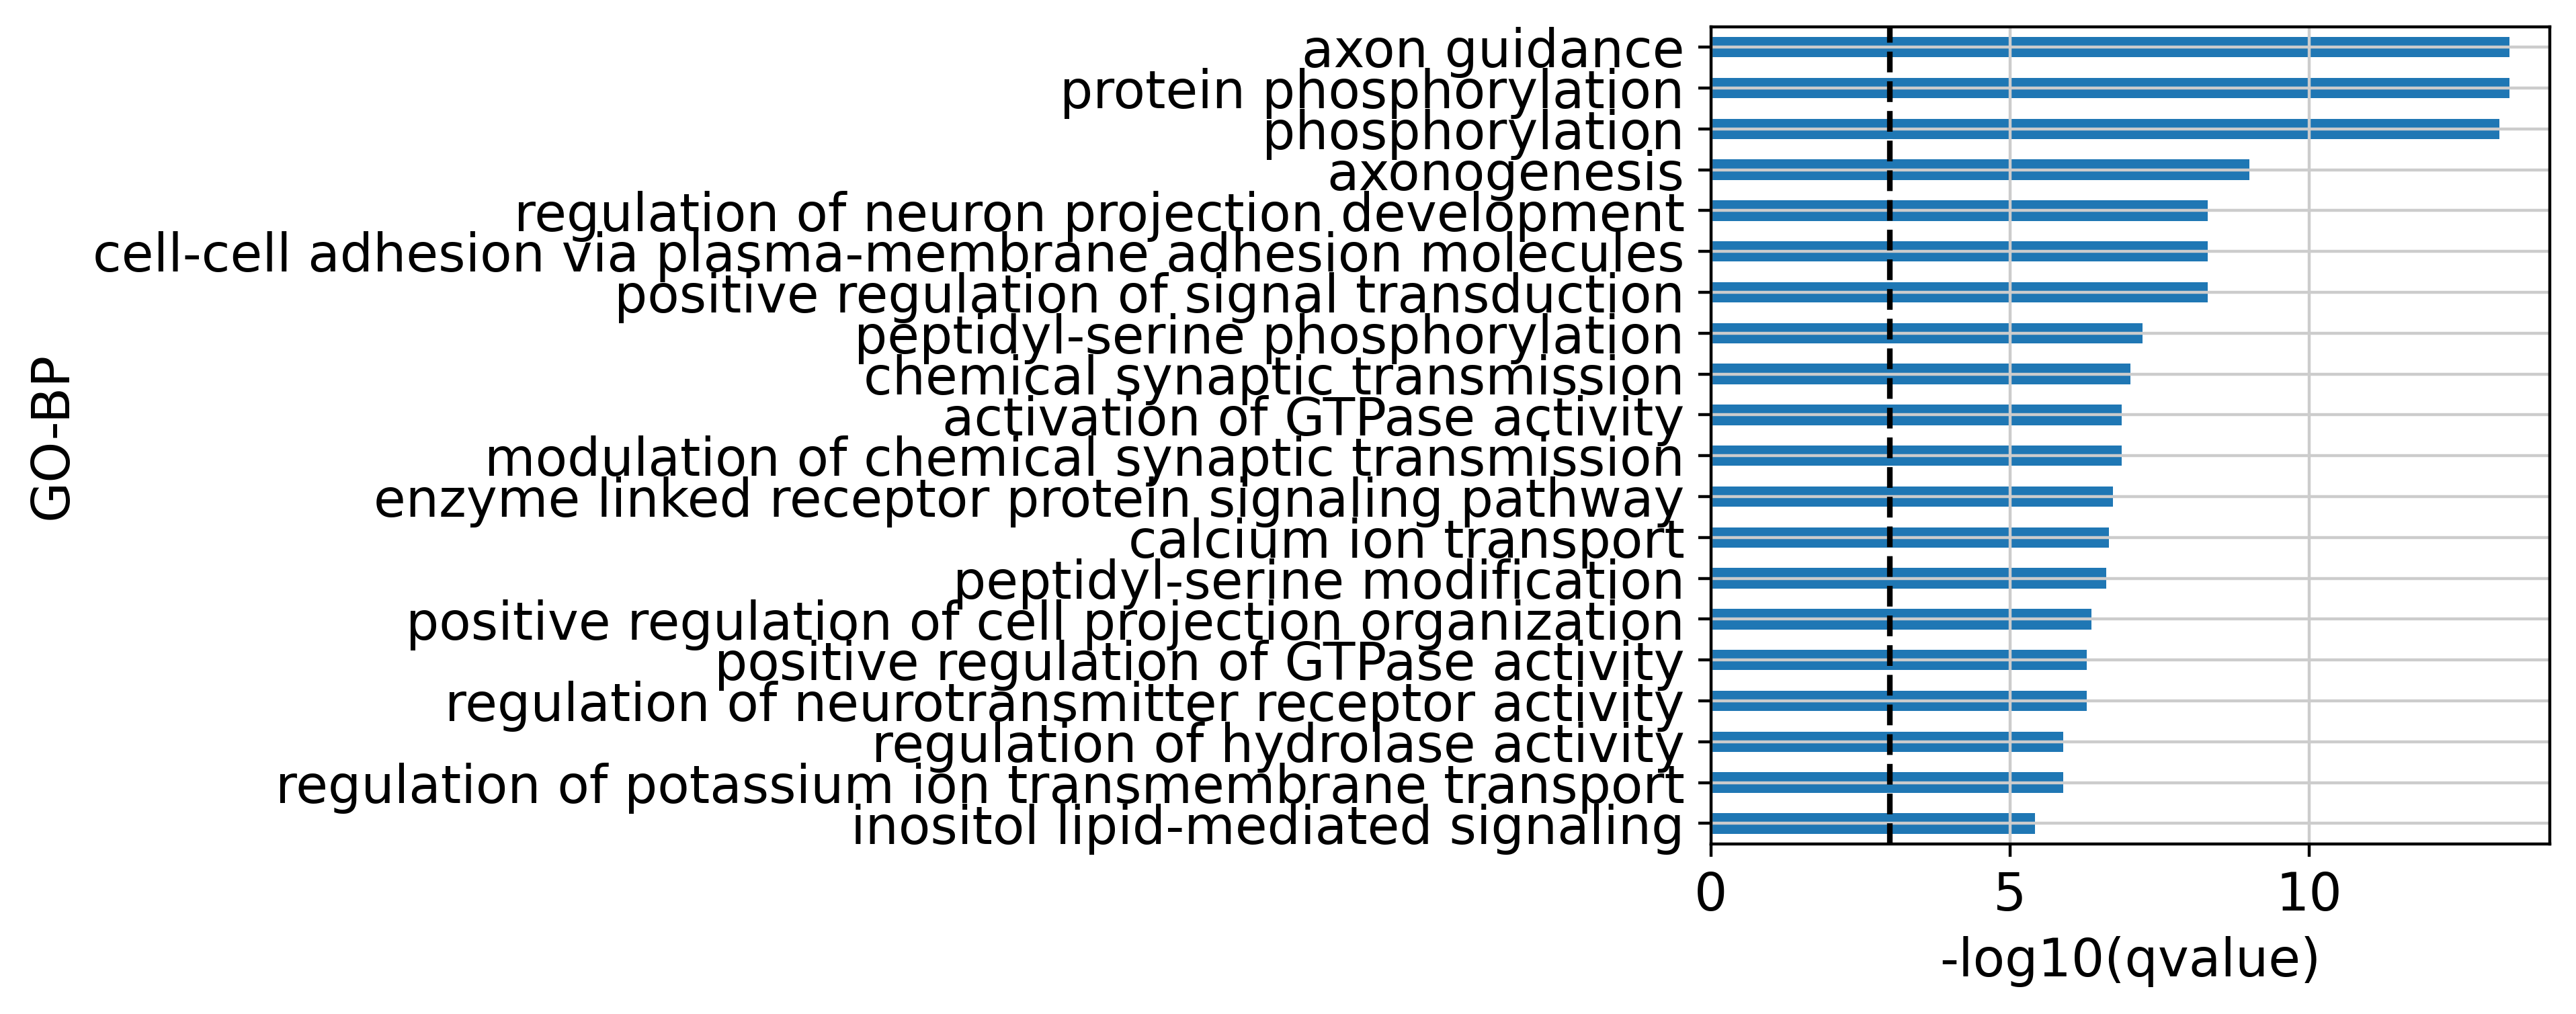

2549 de genes


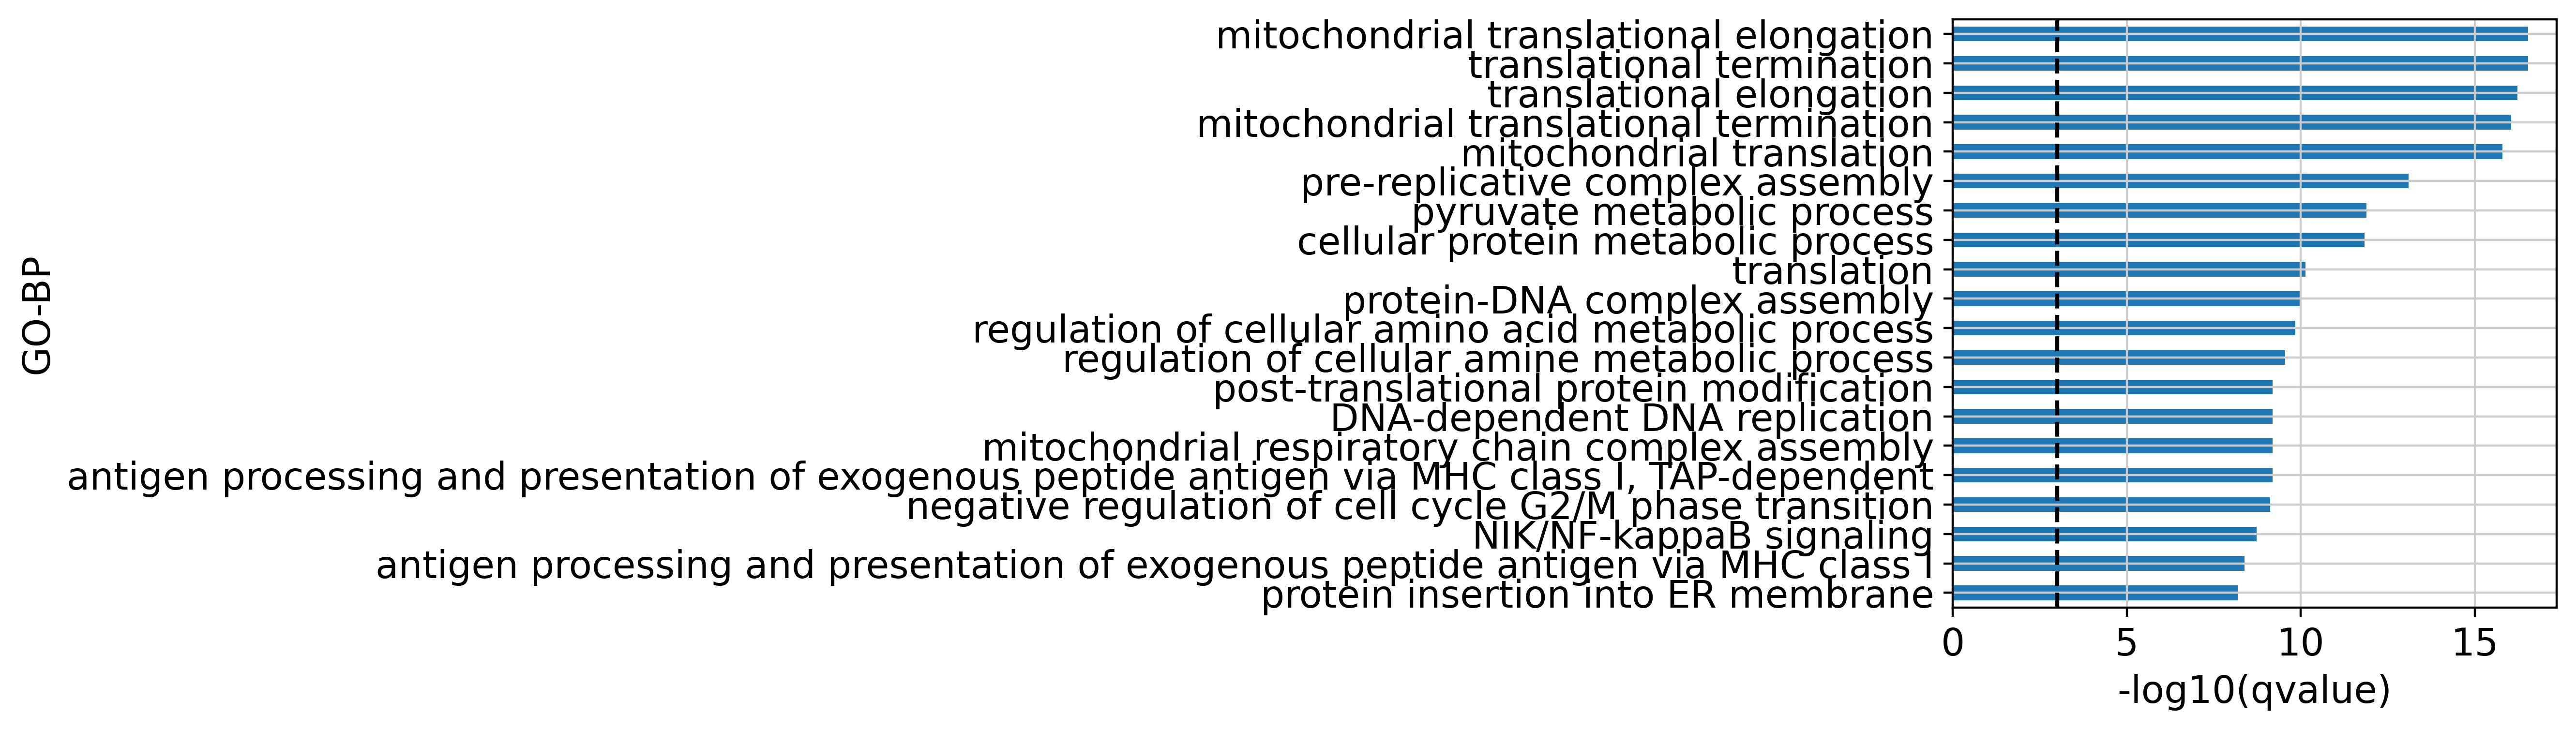

449 de genes
no significant results


<Figure size 800x800 with 0 Axes>

In [266]:
with pd.ExcelWriter("/storage/data/neural_subtype_de/velasco_vs_twoprimary/enrichment_heatmap_clusters.xlsx", engine='xlsxwriter') as writer:
    for i in range(4):
        enr = enrichr(cl[cl.isin([i+1])].index.tolist(), background=cleaned_features, nterms=20)
        plt.savefig(f"/storage/data/neural_subtype_de/velasco_vs_twoprimary/enr_barplots/enrichment_barplot_cluster{i+1}.pdf", dpi=300, bbox_inches="tight")
        plt.show()
        if enr is None:
            enr = pd.DataFrame()
        enr.to_excel(writer, sheet_name=f"cluster_{i+1}")

---